# RAG Testing

In [ ]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.tools import tool
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
import os
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)
from pinecone import Pinecone, ServerlessSpec
from IPython.display import display, clear_output
import ipywidgets as widgets

load_dotenv()

# Initialize Pinecone
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
index_name = "fitness-chatbot"

# Create index if it doesn't exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=768,  # Matches embedding dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)

# Initialize embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

@tool
def retrieve_exercise_info(query: str) -> str:
    """Retrieves science-based exercise information from Pinecone vector store."""
    query_embedding = embeddings.embed_query(query)
    results = index.query(vector=query_embedding, top_k=3, include_metadata=True)
    retrieved_docs = [match["metadata"].get("text", "No text available") for match in results["matches"]]
    return "Retrieved documents:\n" + "\n".join(retrieved_docs)  # Modified to prefix with label






# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", api_key=os.environ.get("OPENAI_API_KEY"))
llm_with_tools = llm.bind_tools([retrieve_exercise_info, 
                                 tool_fetch_workouts,
                                 tool_get_workout_count,
                                 tool_fetch_routines,
                                 tool_update_routine,
                                 tool_create_routine,
                                 retrieve_from_rag])

class AgentState(TypedDict):
    messages: Annotated[list[dict], add_messages]
    session_id: str
    tool_results: dict

def chatbot(state: AgentState) -> dict:
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# Build the graph
graph_builder = StateGraph(AgentState)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[retrieve_exercise_info]))
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

app = graph_builder.compile()



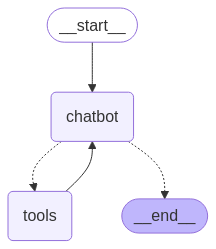

In [10]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
from ipywidgets import widgets, Output
from IPython.display import display, clear_output

# Create widgets
input_box = widgets.Text(placeholder='Type your message here...')
send_button = widgets.Button(description="Send")
output_area = Output()

# Layout
chat_ui = widgets.VBox([
    widgets.HBox([input_box, send_button]),
    output_area
])

def stream_graph_updates(user_input: str):
    with output_area:
        print(f"User: {user_input}")
        for event in app.stream({"messages": [{"role": "user", "content": user_input}]}):
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)
        print("\n---\n")

def on_send_clicked(b):
    user_input = input_box.value
    if user_input.lower() in ["quit", "exit", "q"]:
        with output_area:
            print("Goodbye!")
        return
    
    stream_graph_updates(user_input)
    input_box.value = ''  # Clear input box

# Set up event handler
send_button.on_click(on_send_clicked)

# Display the chat interface
display(chat_ui)

### Next Steps

**1.** Check the retrieved info carefully and see if the agent is inferring from retrieved info or using its existing knowledge.

**2:** If its using existing knowledge, then prompt engineer to prevent that.

**3:** Check quality of retrieved Info. Iterate on diff RAG Techniques to compare the quality.

**4:** If none of them give a good enough quality, try GraphRAG.

**5:** If it still is not good enough quality, try DeepResearch on RAG.

**6:** Final Fallback to web deepresearch.

**7:** Implement rest of the tools.

**8:** Repeat all the quality check steps for rest of the tools, and when everything is passed, then quality check on the whole agent.

**9:** Integrate the final passed Agent into the chatbot backend.

**10:** Incorporate tracking, tracing, prompt versioning etc into the developed agent.

In [1]:
from typing import Annotated, List, Dict, Any, Optional, Literal, Union
from langchain_openai import ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
import os
import json
from datetime import datetime
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)



# Load environment variables and initialize services as you already have
from pinecone import Pinecone, ServerlessSpec
from IPython.display import display, clear_output
import ipywidgets as widgets

load_dotenv()

# Initialize Pinecone
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
index_name = "fitness-chatbot"

# Create index if it doesn't exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=768,  # Matches embedding dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)

# Initialize embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

@tool
def retrieve_exercise_info(query: str) -> str:
    """Retrieves science-based exercise information from Pinecone vector store."""
    query_embedding = embeddings.embed_query(query)
    results = index.query(vector=query_embedding, top_k=3, include_metadata=True)
    retrieved_docs = [match["metadata"].get("text", "No text available") for match in results["matches"]]
    return "Retrieved documents:\n" + "\n".join(retrieved_docs)  # Modified to prefix with label






# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", api_key=os.environ.get("OPENAI_API_KEY"))
llm_with_tools = llm.bind_tools([retrieve_exercise_info, 
                                 tool_fetch_workouts,
                                 tool_get_workout_count,
                                 tool_fetch_routines,
                                 tool_update_routine,
                                 tool_create_routine,
                                 retrieve_from_rag])



# Define the agent state to track conversation and fitness journey
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    session_id: str
    user_profile: Optional[dict]
    assessment_complete: bool
    workout_plan: Optional[dict]
    progress_data: Optional[dict]
    next_step: Literal["assessment", "knowledge_retrieval", "plan_generation", 
                      "progress_analysis", "plan_adjustment", "communication", "end"]
    tool_calls: Optional[List[Dict]]
    tool_results: Optional[Dict]

# Node 1: Assessment - Collects user information
def assessment_node(state: AgentState) -> AgentState:
    """Handle initial user assessment or periodic reassessment."""
    system_prompt = """
    You are an expert personal trainer with deep knowledge of exercise science.
    Your task is to assess the user to create a personalized workout plan.
    
    If this is the first interaction, ask about:
    - Current fitness level and experience with weight training
    - Specific fitness goals (weight loss, muscle gain, strength, etc.)
    - Available workout days and time per session
    - Equipment access (home gym, commercial gym, minimal equipment)
    - Any injuries or health concerns
    - Age, height, and weight (if comfortable sharing)
    
    If this is a reassessment, review their progress and ask about:
    - Satisfaction with current workout plan
    - Any changes to goals or constraints
    - Any new injuries or limitations
    
    Ask questions one at a time to avoid overwhelming the user.
    """
    
    messages = state["messages"] + [SystemMessage(content=system_prompt)]
    response = llm.invoke(messages)
    
    # Check if assessment is complete based on conversation
    # This is simplified - in practice you'd want more sophisticated detection
    assessment_complete = False
    if state.get("user_profile") and all(k in state["user_profile"] for k in 
                                        ["goals", "fitness_level", "available_time", "equipment"]):
        assessment_complete = True
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile", {}),
        "assessment_complete": assessment_complete,
        "next_step": "communication"
    }

# Node 2: Knowledge Retrieval - Gets relevant fitness information from RAG
def knowledge_retrieval_node(state: AgentState) -> AgentState:
    """Query the GraphRAG knowledge base for relevant fitness information."""
    user_profile = state.get("user_profile", {})
    
    # Create relevant queries based on user profile
    queries = [
        f"Recommended exercises for {user_profile.get('goals', 'general fitness')}",
        f"Workout structure for {user_profile.get('fitness_level', 'beginner')} level",
        f"Training frequency for {user_profile.get('goals', 'muscle building')}"
    ]
    
    # Get information from RAG for each query
    retrieved_info = []
    for query in queries:
        result = retrieve_from_rag(query)
        retrieved_info.append(f"Query: {query}\nResults: {result}")
    
    knowledge_summary = "\n\n".join(retrieved_info)
    
    return {
        "messages": state["messages"],
        "session_id": state["session_id"],
        "user_profile": user_profile,
        "assessment_complete": state.get("assessment_complete", False),
        "retrieved_knowledge": knowledge_summary,
        "next_step": "plan_generation"
    }

# Node 3: Plan Generation - Creates workout routines
def plan_generation_node(state: AgentState) -> AgentState:
    """Create a personalized workout plan based on assessment and knowledge."""
    user_profile = state.get("user_profile", {})
    knowledge = state.get("retrieved_knowledge", "")
    
    system_prompt = f"""
    Using your expertise as a personal trainer and the fitness knowledge retrieved,
    create a detailed workout plan for the user.
    
    User profile:
    - Goals: {user_profile.get("goals", "Not specified")}
    - Fitness Level: {user_profile.get("fitness_level", "Not specified")}
    - Available Time: {user_profile.get("available_time", "Not specified")}
    - Equipment: {user_profile.get("equipment", "Not specified")}
    
    Retrieved science-based information:
    {knowledge}
    
    Create a structured workout routine with:
    1. Weekly schedule (which days to train)
    2. Each workout session with:
       - Specific exercises with proper form cues
       - Sets, reps, and rest periods
       - Progressive overload strategy
    
    Format the workout plan in a way that can be used to create routines in the Hevy app.
    """
    
    messages = state["messages"] + [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Here you'd parse the response to create a structured workout plan in Hevy format
    # For simplicity, we'll just store the raw plan
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": user_profile,
        "assessment_complete": True,
        "workout_plan": {"raw_plan": response.content, "created_date": datetime.now().isoformat()},
        "next_step": "communication"
    }

# Node 4: Progress Analysis - Tracks user's fitness journey
def progress_analysis_node(state: AgentState) -> AgentState:
    """Analyze user's workout logs to track progress."""
    
    # Fetch workout data from Hevy API
    recent_workouts = tool_fetch_workouts(page=1, page_size=10)
    workout_count = tool_get_workout_count()
    
    system_prompt = f"""
    As a personal trainer, analyze the user's recent workout data:
    
    Total workouts completed: {workout_count}
    Recent workout logs: {json.dumps(recent_workouts, indent=2)}
    
    Analyze:
    1. Workout consistency (frequency)
    2. Progress in weight/reps over time
    3. Exercise adherence to the plan
    4. Potential plateaus or areas needing attention
    5. Overall progress toward stated goals
    
    Provide a detailed analysis to inform plan adjustments.
    """
    
    messages = [SystemMessage(content=system_prompt)]
    response = llm.invoke(messages)
    
    progress_data = {
        "workout_count": workout_count,
        "recent_workouts": recent_workouts,
        "analysis": response.content,
        "analysis_date": datetime.now().isoformat()
    }
    
    return {
        "messages": state["messages"],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "assessment_complete": state.get("assessment_complete"),
        "workout_plan": state.get("workout_plan"),
        "progress_data": progress_data,
        "next_step": "plan_adjustment"
    }

# Node 5: Plan Adjustment - Modifies workouts based on progress
def plan_adjustment_node(state: AgentState) -> AgentState:
    """Adjust workout plan based on progress analysis."""
    user_profile = state.get("user_profile", {})
    current_plan = state.get("workout_plan", {})
    progress_data = state.get("progress_data", {})
    
    system_prompt = f"""
    As an expert personal trainer, review the user's progress and current workout plan.
    
    User profile: {json.dumps(user_profile, indent=2)}
    Current workout plan: {json.dumps(current_plan, indent=2)}
    Progress analysis: {json.dumps(progress_data, indent=2)}
    
    Determine if the plan needs:
    1. Minor tweaks (increasing weights/reps/sets)
    2. Moderate changes (replacing some exercises)
    3. Major overhaul (new routine based on progress or goal changes)
    
    Update the workout plan with science-based adjustments to ensure continued progress.
    Format the adjusted plan for implementation in the Hevy app.
    """
    
    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Extract adjusted workout plan from response
    adjusted_plan = {
        "raw_plan": response.content, 
        "adjustment_date": datetime.now().isoformat(),
        "previous_plan": current_plan
    }
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "assessment_complete": state.get("assessment_complete"),
        "workout_plan": adjusted_plan,
        "progress_data": state.get("progress_data"),
        "next_step": "communication"
    }

# Node 6: Communication - Handles user interactions
def communication_node(state: AgentState) -> AgentState:
    """Handle user interactions and determine next steps."""
    last_user_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_user_message = msg.content
            break
    
    # Extract key information from messages to update user profile
    if not state.get("assessment_complete", False):
        # Attempt to build/update user profile from conversation
        profile_extractor_prompt = f"""
        Extract key fitness information from this conversation:
        {json.dumps([m.content for m in state["messages"]])}
        
        Return a JSON object with these fields:
        - goals: User's fitness goals
        - fitness_level: Beginner, intermediate, or advanced
        - available_time: Weekly availability for workouts
        - equipment: Available equipment
        - limitations: Any injuries or constraints
        
        Only include fields where information is clearly provided.
        """
        
        extraction_messages = [SystemMessage(content=profile_extractor_prompt)]
        extraction_response = llm.invoke(extraction_messages)
        
        try:
            # Parse profile information
            extracted_profile = json.loads(extraction_response.content)
            current_profile = state.get("user_profile", {})
            updated_profile = {**current_profile, **extracted_profile}
            
            # Check if we have enough information to complete assessment
            required_fields = ["goals", "fitness_level", "available_time", "equipment"]
            assessment_complete = all(field in updated_profile for field in required_fields)
            
            next_step = "knowledge_retrieval" if assessment_complete else "assessment"
            
            return {
                "messages": state["messages"],
                "session_id": state["session_id"],
                "user_profile": updated_profile,
                "assessment_complete": assessment_complete,
                "next_step": next_step
            }
        except:
            # If parsing fails, continue with assessment
            next_step = "assessment"
    
    # If we have a complete profile but no workout plan, generate one
    elif state.get("assessment_complete") and not state.get("workout_plan"):
        next_step = "knowledge_retrieval"
    
    # If we have a workout plan but no recent progress analysis, check progress
    elif state.get("workout_plan") and (not state.get("progress_data") or 
            (datetime.now() - datetime.fromisoformat(state.get("progress_data", {}).get("analysis_date", datetime.now().isoformat()))).days > 7):
        next_step = "progress_analysis"
    
    # Default to ending the interaction
    else:
        next_step = "end"
    
    system_prompt = f"""
    You are a knowledgeable, supportive personal trainer. 
    Be conversational but professional.
    
    User has a fitness profile: {"Yes" if state.get("user_profile") else "No"}
    Assessment complete: {"Yes" if state.get("assessment_complete", False) else "No"}
    Workout plan exists: {"Yes" if state.get("workout_plan") else "No"}
    Progress data available: {"Yes" if state.get("progress_data") else "No"}
    
    Respond to the user's last message. If they ask about their workout plan, explain it.
    If they share results, provide encouragement. If they have questions, answer using
    scientific principles from exercise science.
    """
    
    messages = state["messages"] + [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "assessment_complete": state.get("assessment_complete"),
        "workout_plan": state.get("workout_plan"),
        "progress_data": state.get("progress_data"),
        "next_step": next_step
    }

# Router function to determine the next node
def router(state: AgentState) -> str:
    """Route to the next node based on the state."""
    return state["next_step"]

# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("assessment", assessment_node)
workflow.add_node("knowledge_retrieval", knowledge_retrieval_node)
workflow.add_node("plan_generation", plan_generation_node)
workflow.add_node("progress_analysis", progress_analysis_node)
workflow.add_node("plan_adjustment", plan_adjustment_node)
workflow.add_node("communication", communication_node)
workflow.add_node("tools", ToolNode([
    retrieve_exercise_info, 
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
]))

# Add edges between nodes
workflow.add_conditional_edges(
    "communication",
    router,
    {
        "assessment": "assessment",
        "knowledge_retrieval": "knowledge_retrieval",
        "plan_generation": "plan_generation",
        "progress_analysis": "progress_analysis",
        "plan_adjustment": "plan_adjustment",
        "end": END
    }
)

workflow.add_conditional_edges(
    "assessment",
    router,
    {
        "knowledge_retrieval": "knowledge_retrieval",
        "communication": "communication",
        "end": END
    }
)

workflow.add_conditional_edges(
    "knowledge_retrieval",
    router,
    {
        "plan_generation": "plan_generation",
        "end": END
    }
)

workflow.add_conditional_edges(
    "plan_generation",
    router,
    {
        "communication": "communication",
        "end": END
    }
)

workflow.add_conditional_edges(
    "progress_analysis",
    router,
    {
        "plan_adjustment": "plan_adjustment",
        "end": END
    }
)

workflow.add_conditional_edges(
    "plan_adjustment",
    router,
    {
        "communication": "communication",
        "end": END
    }
)

# Add conditional edges for tool usage
for node in ["assessment", "knowledge_retrieval", "plan_generation", 
             "progress_analysis", "plan_adjustment", "communication"]:
    workflow.add_conditional_edges(
        node,
        tools_condition,
        {
            True: "tools",
            False: node  # Stay in the same node if no tools needed
        }
    )

workflow.add_edge("tools", "communication")

# Set entry point
workflow.set_entry_point("communication")

# Compile the graph
app = workflow.compile()

# Function to run the agent with user input
# def run_fitness_coach(user_input: str, session_id: str, state=None):
#     """Run the personal trainer agent with user input."""
#     if state is None:
#         initial_state = {
#             "messages": [HumanMessage(content=user_input)],
#             "session_id": session_id,
#             "next_step": "communication"
#         }
#     else:
#         # Add the new message to existing state
#         state["messages"].append(HumanMessage(content=user_input))
#         initial_state = state
    
#     # Run the workflow
#     final_state = app.invoke(initial_state)
#     return final_state


/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [24]:
mermaid_diagram = app.get_graph().draw_mermaid()
print(mermaid_diagram)






%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	assessment(assessment)
	knowledge_retrieval(knowledge_retrieval)
	plan_generation(plan_generation)
	progress_analysis(progress_analysis)
	plan_adjustment(plan_adjustment)
	communication(communication)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> communication;
	tools --> communication;
	communication -.-> assessment;
	communication -.-> knowledge_retrieval;
	communication -.-> plan_generation;
	communication -.-> progress_analysis;
	communication -.-> plan_adjustment;
	communication -. &nbsp;end&nbsp; .-> __end__;
	communication -. &nbsp;True&nbsp; .-> tools;
	assessment -.-> knowledge_retrieval;
	assessment -.-> communication;
	assessment -. &nbsp;end&nbsp; .-> __end__;
	assessment -. &nbsp;True&nbsp; .-> tools;
	knowledge_retrieval -.-> plan_generation;
	knowledge_retrieval -. &nbsp;end&nbsp; .-> __end__;
	knowledge_retrieval -. &nbsp;True&nbsp; .-> tools;
	plan_generati

In [17]:
import time
from IPython.display import Image, display
import requests

def get_mermaid_image(url, retries=3, timeout=20):
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=timeout)
            response.raise_for_status()  # Raise an exception for HTTP errors
            return response.content
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            time.sleep(2)  # Wait before retrying
    return None

# Assuming app.get_graph().draw_mermaid_png() returns a URL:
image_url = app.get_graph().draw_mermaid_png()
image_content = get_mermaid_image(image_url)

if image_content:
    display(Image(image_content))
else:
    print("Failed to retrieve the Mermaid diagram after several attempts.")


ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [18]:
diagram_code = app.get_graph().mermaid_code()

AttributeError: 'Graph' object has no attribute 'mermaid_code'

In [19]:
mermaid_diagram = app.get_graph().to_mermaid()
print(mermaid_diagram)

AttributeError: 'Graph' object has no attribute 'to_mermaid'

# Level 1 Agent

In [25]:
from typing import Annotated, List, Dict, Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
import os
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)

# Load environment variables and initialize services
load_dotenv()

# Define the agent state
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    session_id: str
    tool_calls: Optional[List[Dict]]
    tool_results: Optional[Dict]

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", api_key=os.environ.get("OPENAI_API_KEY"))

# Create the system prompt with detailed instructions
system_prompt = """You are an expert personal fitness trainer with deep knowledge of exercise science.

Your capabilities:
1. Assessment: You can ask relevant questions to understand the user's fitness level, goals, and constraints
2. Knowledge: You have access to exercise science information through the retrieve_from_rag tool
3. Workout Planning: You can create personalized routines using scientific principles
4. Progress Tracking: You can analyze workout logs from Hevy using the tool_fetch_workouts tool
5. Plan Adjustment: You can modify workouts based on progress and feedback

When working with a new user:
- Ask about their fitness goals, experience level, available equipment, and schedule
- Be conversational but thorough in your assessment
- Use retrieve_from_rag to get scientific information about appropriate exercises
- Create a personalized workout plan
- Use tool_create_routine to save the workout to their Hevy account

For returning users:
- Check their progress using tool_fetch_workouts and tool_get_workout_count
- Analyze their adherence and performance
- Suggest modifications to their routine as needed
- Use tool_update_routine to modify existing routines

Always provide scientific rationale for your recommendations and maintain a supportive, motivational tone.
"""

# Define the main agent node
def fitness_agent(state: AgentState) -> AgentState:
    """The main fitness trainer agent that handles all aspects of the interaction."""
    # Add the system prompt for first-time messages
    if len(state["messages"]) == 1 and isinstance(state["messages"][0], HumanMessage):
        messages = [SystemMessage(content=system_prompt)] + state["messages"]
    else:
        messages = state["messages"]
        
    # Invoke the model with tools
    response = llm_with_tools.invoke(messages)
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "tool_calls": response.tool_calls if hasattr(response, "tool_calls") else None
    }

# Define the graph
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("fitness_agent", fitness_agent)
graph.add_node("tools", ToolNode([
    retrieve_exercise_info, 
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
]))

# Add edges
graph.add_conditional_edges(
    "fitness_agent",
    tools_condition,
    {
        True: "tools",
        False: END
    }
)
graph.add_edge("tools", "fitness_agent")

# Set entry point
graph.set_entry_point("fitness_agent")

# Compile the graph
app = graph.compile()


In [26]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
mermaid_diagram = app.get_graph().draw_mermaid()
print(mermaid_diagram)

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	fitness_agent(fitness_agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> fitness_agent;
	tools --> fitness_agent;
	fitness_agent -. &nbsp;True&nbsp; .-> tools;
	fitness_agent -. &nbsp;False&nbsp; .-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



# Level 2 Agent

In [42]:
from typing import Annotated, List, Dict, Any, Optional, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)

# Define the agent state
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    session_id: str
    user_profile: Optional[dict]
    workout_plan: Optional[dict]
    progress_data: Optional[dict]
    stage: Literal["assessment", "planning", "monitoring"]
    tool_calls: Optional[List[Dict]]
    tool_results: Optional[Dict]

# Assessment stage - handles user profiling and goal setting
def assessment_stage(state: AgentState) -> AgentState:
    assessment_prompt = """You are a fitness expert in the assessment phase.
    Ask targeted questions about the user's:
    1. Fitness goals (strength, endurance, weight loss, etc.)
    2. Training history and current fitness level
    3. Available equipment and schedule
    4. Any health concerns or limitations
    
    Use the information to build a comprehensive user profile.
    """
    
    messages = state["messages"] + [SystemMessage(content=assessment_prompt)]
    response = llm.invoke(messages)
    
    # Extract profile information from conversation if possible
    # (code for profile extraction would go here)
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile", {}),
        "stage": "planning" if state.get("user_profile") else "assessment"
    }

# Planning stage - creates workout routines
def planning_stage(state: AgentState) -> AgentState:
    planning_prompt = """You are a fitness expert in the planning phase.
    Use the user profile and retrieve_from_rag to create a personalized workout plan.
    Include:
    1. Weekly schedule breakdown
    2. Specific exercises with sets, reps, and rest periods
    3. Progression scheme over time
    4. Format the plan for Hevy app integration
    
    Explain the scientific rationale behind each element of the plan.
    """
    
    messages = state["messages"] + [SystemMessage(content=planning_prompt)]
    response = llm_with_tools.invoke(messages)
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "workout_plan": {"content": response.content, "created": "now"},
        "stage": "monitoring"
    }

# Monitoring stage - tracks progress and adjusts plans
def monitoring_stage(state: AgentState) -> AgentState:
    monitoring_prompt = """You are a fitness expert in the monitoring phase.
    Analyze the user's workout logs from the Hevy API and:
    1. Track adherence to the workout plan
    2. Identify progress or plateaus
    3. Suggest adjustments to the plan as needed
    4. Provide motivation and science-based advice
    
    Use tool_fetch_workouts to view recent activity.
    """
    
    messages = state["messages"] + [SystemMessage(content=monitoring_prompt)]
    response = llm_with_tools.invoke(messages)
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "workout_plan": state.get("workout_plan"),
        "stage": "monitoring"  # Stay in monitoring once we reach it
    }

# Stage router
def stage_router(state: AgentState) -> str:
    return state["stage"]

# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("assessment", assessment_stage)
workflow.add_node("planning", planning_stage)
workflow.add_node("monitoring", monitoring_stage)
workflow.add_node("tools", ToolNode([retrieve_from_rag, tool_fetch_workouts]))

# Add edges
workflow.add_conditional_edges(
    "assessment",
    stage_router,
    {
        "planning": "planning"
    }
)
workflow.add_conditional_edges(
    "planning",
    stage_router,
    {
        "monitoring": "monitoring"
    }
)
workflow.add_conditional_edges(
    "monitoring",
    stage_router,
    {
        "planning": "planning",  # Allow returning to planning for major updates
        "end": END  # Allow ending the conversation
    }
)

# Add tool usage edges
for node in ["assessment", "planning", "monitoring"]:
    workflow.add_conditional_edges(
        node,
        tools_condition,
        {
            True: "tools",
            False: node
        }
    )

workflow.add_conditional_edges("tools",
                               lambda state: state['stage'],
                               {
                                   "assessment":"assessment",
                                   "planning":"planning",
                                   "monitoring":"monitoring"
                               })

workflow.set_entry_point("assessment")

level2_app = workflow.compile()


# Level 3 Agent

In [36]:
from typing import Annotated, List, Dict, Any, Optional, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)

# Define the agent state with more detailed tracking
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    session_id: str
    user_profile: Optional[dict]
    workout_plan: Optional[dict]
    progress_data: Optional[dict]
    training_history: Optional[List[Dict]]
    analysis_results: Optional[Dict]
    next_action: Literal["orchestrate", "assess", "research", "plan", "analyze", "adjust", "end"]
    context: Dict[str, Any]  # For sharing context between nodes
    tool_calls: Optional[List[Dict]]
    tool_results: Optional[Dict]

# Orchestrator - central coordinator that decides workflow
def orchestrator_node(state: AgentState) -> AgentState:
    """Determines which specialized node should handle the current interaction."""
    
    orchestrator_prompt = """You are the coordinator of a fitness training system.
    Based on the conversation history and user needs, determine the next appropriate action:
    
    - "assess": When we need to gather information about the user
    - "research": When we need to retrieve exercise science information
    - "plan": When we need to create a new workout routine
    - "analyze": When we need to analyze workout data and progress
    - "adjust": When we need to modify an existing workout plan
    - "end": When the interaction is complete
    
    Consider the user's profile completeness, workout plan existence, and recent progress.
    """
    
    # Add thinking context for the orchestrator
    context_summary = {
        "has_profile": bool(state.get("user_profile")),
        "has_workout_plan": bool(state.get("workout_plan")),
        "has_progress_data": bool(state.get("progress_data")),
        "training_history_count": len(state.get("training_history", [])),
        "last_action": state.get("next_action", "orchestrate")
    }
    
    messages = [
        SystemMessage(content=orchestrator_prompt),
        HumanMessage(content=f"Context: {context_summary}\n\nDecide the next action based on the conversation history: {state['messages'][-1].content if state['messages'] else 'Initial interaction'}")
    ]
    
    response = llm.invoke(messages)
    
    # Extract the next action from the response
    action_mapping = {
        "assess": "assess",
        "research": "research",
        "plan": "plan", 
        "analyze": "analyze",
        "adjust": "adjust",
        "end": "end"
    }
    
    # Simple parsing (in real system, would be more robust)
    next_action = "orchestrate"  # Default
    for action in action_mapping:
        if action in response.content.lower():
            next_action = action_mapping[action]
            break
    
    # Update context with orchestrator's reasoning
    context = state.get("context", {})
    context["orchestrator_reasoning"] = response.content
    
    return {
        "messages": state["messages"],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "workout_plan": state.get("workout_plan"),
        "progress_data": state.get("progress_data"),
        "training_history": state.get("training_history", []),
        "next_action": next_action,
        "context": context
    }

# Assessment Worker - gathers user information
def assessment_worker(state: AgentState) -> AgentState:
    """Handles user assessment and profile building."""
    
    assessment_prompt = """You are a fitness assessment specialist.
    Ask targeted questions to build a comprehensive user profile.
    Focus on gathering missing information based on what you already know.
    
    Current profile: {{user_profile}}
    
    Areas to assess:
    - Fitness goals and priorities
    - Training experience and current level
    - Available equipment and schedule
    - Physical limitations or health concerns
    - Measurement data (if willing to share)
    
    Be conversational but thorough.
    """
    
    # Customize the prompt with current profile
    filled_prompt = assessment_prompt.replace(
        "{{user_profile}}", 
        str(state.get("user_profile", "No existing profile"))
    )
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # In a real system, we'd have logic to extract profile information
    # and update the user_profile dictionary
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile", {}),
        "workout_plan": state.get("workout_plan"),
        "progress_data": state.get("progress_data"),
        "training_history": state.get("training_history", []),
        "next_action": "orchestrate",  # Return to orchestrator
        "context": state.get("context", {})
    }

# Research Worker - retrieves exercise science information
def research_worker(state: AgentState) -> AgentState:
    """Retrieves relevant exercise science information."""
    
    research_prompt = """You are a fitness research specialist.
    Based on the user's profile and current needs, retrieve relevant exercise science information.
    Use the retrieve_from_rag tool to find scientific information about:
    
    - Optimal training approaches for the user's goals
    - Exercise selection based on equipment and limitations
    - Evidence-based progression schemes
    - Recovery and periodization strategies
    
    Organize your findings in a clear, structured way.
    """
    
    context = state.get("context", {})
    research_needed = context.get("research_topics", ["general training principles"])
    
    # Add research topics to prompt
    research_prompt += f"\n\nSpecific topics to research: {', '.join(research_needed)}"
    
    messages = state["messages"] + [SystemMessage(content=research_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update context with research findings
    context["research_findings"] = response.content
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "workout_plan": state.get("workout_plan"),
        "progress_data": state.get("progress_data"),
        "training_history": state.get("training_history", []),
        "next_action": "orchestrate",
        "context": context
    }

# Planning Worker - creates workout routines
def planning_worker(state: AgentState) -> AgentState:
    """Creates personalized workout plans."""
    
    planning_prompt = """You are a workout programming specialist.
    Create a detailed, personalized workout plan for the user.
    
    User profile: {{user_profile}}
    Research findings: {{research_findings}}
    
    Your plan should include:
    1. Weekly schedule with workout days and focus areas
    2. Detailed workout structure for each session
       - Specific exercises with sets, reps, rest periods
       - Warm-up routines and cool-down stretches
       - Form cues and technique notes
    3. Progression scheme for 4-6 weeks
    4. Structured format ready for Hevy app integration
    
    Explain the scientific rationale behind your choices.
    """
    
    context = state.get("context", {})
    
    # Customize the prompt
    filled_prompt = planning_prompt.replace(
        "{{user_profile}}", 
        str(state.get("user_profile", "No profile available"))
    ).replace(
        "{{research_findings}}",
        context.get("research_findings", "No research findings available")
    )
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Create workout plan structure
    workout_plan = {
        "content": response.content,
        "created_date": "current_date",
        "version": 1.0,
        "hevy_routines": []  # Would contain IDs of created Hevy routines
    }
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "workout_plan": workout_plan,
        "progress_data": state.get("progress_data"),
        "training_history": state.get("training_history", []),
        "next_action": "orchestrate",
        "context": context
    }

# Analysis Worker - analyzes workout data
def analysis_worker(state: AgentState) -> AgentState:
    """Analyzes workout logs and progress."""
    
    analysis_prompt = """You are a fitness data analyst.
    Retrieve and analyze the user's workout logs to assess progress.
    
    Use these tools:
    - tool_fetch_workouts: Get recent workout data
    - tool_get_workout_count: Check overall workout volume
    
    Analyze:
    1. Workout adherence and consistency
    2. Progress in key metrics (weight, reps, sets)
    3. Comparison to the workout plan
    4. Potential plateaus or areas needing attention
    
    Provide objective analysis backed by data.
    """
    
    messages = state["messages"] + [SystemMessage(content=analysis_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Structure the analysis results
    analysis_results = {
        "analysis": response.content,
        "date": "current_date",
        "key_metrics": {},  # Would contain extracted metrics
        "recommendations": []  # Would contain extracted recommendations
    }
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "workout_plan": state.get("workout_plan"),
        "progress_data": state.get("progress_data"),
        "training_history": state.get("training_history", []),
        "analysis_results": analysis_results,
        "next_action": "orchestrate",
        "context": state.get("context", {})
    }

# Adjustment Worker - modifies workout plans
def adjustment_worker(state: AgentState) -> AgentState:
    """Adjusts workout plans based on analysis."""
    
    adjustment_prompt = """You are a workout optimization specialist.
    Adjust the user's workout plan based on progress analysis.
    
    Current plan: {{workout_plan}}
    Analysis results: {{analysis_results}}
    User profile: {{user_profile}}
    
    Determine the appropriate level of adjustment:
    1. Minor: Adjust weights, reps, or sets
    2. Moderate: Substitute exercises or change training variables
    3. Major: Create a new phase or approach
    
    Use tool_update_routine to implement changes in Hevy.
    
    Explain the scientific rationale for each adjustment.
    """
    
    # Customize the prompt
    filled_prompt = adjustment_prompt.replace(
        "{{workout_plan}}",
        str(state.get("workout_plan", "No plan available"))
    ).replace(
        "{{analysis_results}}",
        str(state.get("analysis_results", "No analysis available"))
    ).replace(
        "{{user_profile}}",
        str(state.get("user_profile", "No profile available"))
    )
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update the workout plan with adjustments
    current_plan = state.get("workout_plan", {})
    adjusted_plan = {
        **current_plan,
        "adjusted_content": response.content,
        "adjustment_date": "current_date",
        "version": current_plan.get("version", 1.0) + 0.1
    }
    
    return {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": state["session_id"],
        "user_profile": state.get("user_profile"),
        "workout_plan": adjusted_plan,
        "progress_data": state.get("progress_data"),
        "training_history": state.get("training_history", []),
        "next_action": "orchestrate",
        "context": state.get("context", {})
    }

# Action router
def action_router(state: AgentState) -> str:
    return state["next_action"]

# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("orchestrator", orchestrator_node)
workflow.add_node("assess", assessment_worker)
workflow.add_node("research", research_worker)
workflow.add_node("plan", planning_worker)
workflow.add_node("analyze", analysis_worker)
workflow.add_node("adjust", adjustment_worker)
workflow.add_node("tools", ToolNode([
    retrieve_from_rag, 
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine
]))

# Add orchestrator routing
workflow.add_conditional_edges(
    "orchestrator",
    action_router,
    {
        "assess": "assess",
        "research": "research",
        "plan": "plan",
        "analyze": "analyze",
        "adjust": "adjust",
        "orchestrate": "orchestrator",
        "end": END
    }
)

# Add return edges to orchestrator
for node in ["assess", "research", "plan", "analyze", "adjust"]:
    workflow.add_conditional_edges(
        node,
        action_router,
        {
            "orchestrate": "orchestrator",
        }
    )

# Add tool usage for all nodes
for node in ["assess", "research", "plan", "analyze", "adjust"]:
    workflow.add_conditional_edges(
        node,
        tools_condition,
        {
            True: "tools",
            False: node
        }
    )

# Tool return edges
workflow.add_conditional_edges(
    "tools",
    lambda state: state["next_action"],
    {
        "orchestrate": "orchestrator",
        "assess": "assess",
        "research": "research",
        "plan": "plan",
        "analyze": "analyze",
        "adjust": "adjust"
    }
)


workflow.set_entry_point("orchestrator")

level3_app = workflow.compile()

In [43]:
level2_diagram = level2_app.get_graph().draw_mermaid()
level3_diagram = level3_app.get_graph().draw_mermaid()


# Level 4 Agent

In [ ]:
from typing import Annotated, List, Dict, Any, Optional, Literal, Union, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, FunctionMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from datetime import datetime, timedelta
import json
import uuid
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)

# Define more sophisticated state model
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    session_id: str
    memory: Dict[str, Any]  # Long-term memory storage
    working_memory: Dict[str, Any]  # Short-term contextual memory
    user_model: Dict[str, Any]  # Comprehensive user model
    fitness_plan: Dict[str, Any]  # Structured fitness plan
    reasoning_trace: List[Dict[str, Any]]  # Traces of reasoning steps
    agent_state: Dict[str, str]  # Current state of each agent
    current_agent: str  # Currently active agent
    tool_calls: Optional[List[Dict]]
    tool_results: Optional[Dict]

# Memory manager for sophisticated state management
def memory_manager(state: AgentState) -> AgentState:
    """Manages long-term and working memory, consolidating information and pruning as needed."""
    
    memory_prompt = """You are the memory manager for a fitness training system.
    Review the conversation history and current agent states to:
    
    1. Identify key information that should be stored in long-term memory
    2. Update the user model with new insights
    3. Consolidate redundant information
    4. Prune outdated or superseded information
    5. Ensure critical context is available in working memory
    
    Current long-term memory: {{memory}}
    Current user model: {{user_model}}
    Current working memory: {{working_memory}}
    
    Return a structured update of what should be stored, updated, or removed.
    """
    
    # Fill template
    filled_prompt = memory_prompt.replace("{{memory}}", str(state.get("memory", {})))
    filled_prompt = filled_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = filled_prompt.replace("{{working_memory}}", str(state.get("working_memory", {})))
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Parse and update memory structures
    # This would include sophisticated logic to maintain memory integrity
    
    # For this example, we'll make a simple update
    memory = state.get("memory", {})
    working_memory = state.get("working_memory", {})
    user_model = state.get("user_model", {})
    
    # Extract recent messages for context
    recent_exchanges = []
    for msg in state["messages"][-10:]:  # Last 10 messages
        if isinstance(msg, HumanMessage) or isinstance(msg, AIMessage):
            recent_exchanges.append({"role": "user" if isinstance(msg, HumanMessage) else "assistant", 
                                    "content": msg.content})
    
    # Update working memory with recent context
    working_memory["recent_exchanges"] = recent_exchanges
    working_memory["last_updated"] = datetime.now().isoformat()
    
    # Track agent interactions in memory
    memory_key = f"interaction_{datetime.now().isoformat()}"
    memory[memory_key] = {
        "agent_states": state.get("agent_state", {}),
        "current_agent": state.get("current_agent", "coordinator"),
        "user_intent": working_memory.get("current_user_intent", "unknown")
    }
    
    return {
        **state,
        "memory": memory,
        "working_memory": working_memory,
        "user_model": user_model
    }

# Reasoning engine for sophisticated decision-making
def reasoning_engine(state: AgentState) -> AgentState:
    """Advanced reasoning to determine the optimal next steps and actions."""
    
    reasoning_prompt = """You are the reasoning engine for a fitness training system.
    Analyze the current situation using sophisticated reasoning to determine:
    
    1. What is the user's current need or intent?
    2. What information do we currently have and what's missing?
    3. What potential approaches could address the user's needs?
    4. What are the tradeoffs between different approaches?
    5. What is the optimal next action given all constraints?
    
    User model: {{user_model}}
    Working memory: {{working_memory}}
    Fitness plan: {{fitness_plan}}
    
    Think step by step and document your reasoning process.
    """
    
    # Fill template
    filled_prompt = reasoning_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = filled_prompt.replace("{{working_memory}}", str(state.get("working_memory", {})))
    filled_prompt = filled_prompt.replace("{{fitness_plan}}", str(state.get("fitness_plan", {})))
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Extract reasoning trace
    reasoning_trace = state.get("reasoning_trace", [])
    reasoning_trace.append({
        "timestamp": datetime.now().isoformat(),
        "reasoning": response.content,
        "context": {
            "current_agent": state.get("current_agent"),
            "working_memory_snapshot": state.get("working_memory", {})
        }
    })
    
    # Determine next agent based on reasoning
    # Extract key insights to guide agent selection
    agent_selection = "coordinator"  # Default
    
    if "assessment" in response.content.lower() or "profile" in response.content.lower():
        agent_selection = "profiler_agent"
    elif "research" in response.content.lower() or "knowledge" in response.content.lower():
        agent_selection = "research_agent"
    elif "plan" in response.content.lower() or "routine" in response.content.lower():
        agent_selection = "planner_agent"
    elif "progress" in response.content.lower() or "analyze" in response.content.lower():
        agent_selection = "analyst_agent"
    elif "adjust" in response.content.lower() or "modify" in response.content.lower():
        agent_selection = "adaptation_agent"
    elif "motivate" in response.content.lower() or "coach" in response.content.lower():
        agent_selection = "coach_agent"
    
    # Update working memory with reasoning results
    working_memory = state.get("working_memory", {})
    working_memory["reasoning_summary"] = response.content
    working_memory["selected_agent"] = agent_selection
    
    return {
        **state,
        "reasoning_trace": reasoning_trace,
        "current_agent": agent_selection,
        "working_memory": working_memory
    }

# User modeler for comprehensive user understanding
def user_modeler(state: AgentState) -> AgentState:
    """Builds and maintains a comprehensive model of the user."""
    
    modeling_prompt = """You are a user modeling specialist for a fitness training system.
    Analyze all available information about the user to build a comprehensive model:
    
    1. Extract explicit information (stated goals, preferences, constraints)
    2. Infer implicit information (fitness level, motivation factors, learning style)
    3. Identify gaps in our understanding that need to be addressed
    4. Update confidence levels for different aspects of the model
    
    Current user model: {{user_model}}
    Recent exchanges: {{recent_exchanges}}
    
    Return an updated user model with confidence scores for each attribute.
    """
    
    # Fill template
    filled_prompt = modeling_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = filled_prompt.replace("{{recent_exchanges}}", 
                                         str(state.get("working_memory", {}).get("recent_exchanges", [])))
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Parse and update user model
    # In a real system, we'd have sophisticated parsing and model updating
    
    # Simple example update
    user_model = state.get("user_model", {})
    user_model["last_updated"] = datetime.now().isoformat()
    user_model["model_version"] = user_model.get("model_version", 0) + 1
    
    # Extract goals if mentioned in recent messages
    for msg in state["messages"][-5:]:
        if isinstance(msg, HumanMessage) and "goal" in msg.content.lower():
            user_model["has_explicit_goals"] = True
    
    return {
        **state,
        "user_model": user_model
    }

# Agent coordinator for orchestrating the multi-agent system
def coordinator_agent(state: AgentState) -> AgentState:
    """Coordinates the multi-agent system and handles high-level decision making."""
    
    coordinator_prompt = """You are the coordinator for a fitness training multi-agent system.
    
    Current agent states:
    {{agent_states}}
    
    Reasoning summary:
    {{reasoning_summary}}
    
    Selected agent: {{selected_agent}}
    
    Your tasks:
    1. Ensure smooth transitions between agents
    2. Maintain conversation coherence across agent handoffs
    3. Resolve conflicts between agent recommendations
    4. Determine when to invoke specialized agents vs. handling directly
    
    If you're responding to the user directly, maintain a supportive, expert tone.
    """
    
    # Fill template with state information
    filled_prompt = coordinator_prompt.replace("{{agent_states}}", str(state.get("agent_state", {})))
    filled_prompt = filled_prompt.replace("{{reasoning_summary}}", 
                                         str(state.get("working_memory", {}).get("reasoning_summary", "")))
    filled_prompt = filled_prompt.replace("{{selected_agent}}", 
                                         state.get("working_memory", {}).get("selected_agent", "coordinator"))
    
    # If user message is the last one, respond
    last_message_is_user = False
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_message_is_user = True
            break
        elif isinstance(msg, AIMessage):
            last_message_is_user = False
            break
    
    if last_message_is_user:
        messages = state["messages"] + [SystemMessage(content=filled_prompt)]
        response = llm_with_tools.invoke(messages)
        
        return {
            **state,
            "messages": state["messages"] + [AIMessage(content=response.content)],
            "current_agent": "coordinator"
        }
    else:
        # Just update state without responding
        return state

# Specialized profiler agent for in-depth user assessment
def profiler_agent(state: AgentState) -> AgentState:
    """Specialized agent for in-depth user assessment and profiling."""
    
    profiler_prompt = """You are a fitness assessment and profiling specialist.
    
    User model: {{user_model}}
    
    Your specialized capabilities:
    1. Comprehensive fitness assessment methodology
    2. Psychological profiling for motivation and adherence factors
    3. Goal elicitation and refinement techniques
    4. Learning style and communication preference assessment
    
    Ask targeted questions based on gaps in the user model.
    Focus on building a complete picture of the user's needs and constraints.
    """
    
    # Fill template
    filled_prompt = profiler_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update agent state
    agent_state = state.get("agent_state", {})
    agent_state["profiler_agent"] = "active"
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "current_agent": "profiler_agent",
        "agent_state": agent_state
    }

# Research specialist agent for fitness knowledge
def research_agent(state: AgentState) -> AgentState:
    """Specialized agent for retrieving and synthesizing fitness knowledge."""
    
    research_prompt = """You are a fitness research and knowledge specialist.
    
    User model: {{user_model}}
    Working memory: {{working_memory}}
    
    Your specialized capabilities:
    1. Access to evidence-based fitness research
    2. Critical analysis of fitness methodologies
    3. Translation of scientific concepts to practical applications
    4. Personalized recommendations based on research findings
    
    Use the retrieve_from_rag tool to access relevant scientific information.
    Synthesize findings in a clear, actionable manner relevant to the user's needs.
    """
    
    # Fill template
    filled_prompt = research_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = filled_prompt.replace("{{working_memory}}", str(state.get("working_memory", {})))
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update agent state
    agent_state = state.get("agent_state", {})
    agent_state["research_agent"] = "active"
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "current_agent": "research_agent",
        "agent_state": agent_state
    }

# Program design specialist agent
def planner_agent(state: AgentState) -> AgentState:
    """Specialized agent for creating sophisticated workout plans."""
    
    planner_prompt = """You are a fitness program design specialist.
    
    User model: {{user_model}}
    Working memory: {{working_memory}}
    
    Your specialized capabilities:
    1. Periodized program design based on sports science principles
    2. Exercise selection optimization for specific goals
    3. Progression modeling for continuous adaptation
    4. Integration of recovery and volume management
    
    Create a scientifically-sound, personalized workout plan.
    Format the plan for implementation in the Hevy app.
    """
    
    # Fill template
    filled_prompt = planner_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = filled_prompt.replace("{{working_memory}}", str(state.get("working_memory", {})))
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update agent state
    agent_state = state.get("agent_state", {})
    agent_state["planner_agent"] = "active"
    
    # Store the workout plan
    fitness_plan = state.get("fitness_plan", {})
    fitness_plan["plan_content"] = response.content
    fitness_plan["created_date"] = datetime.now().isoformat()
    fitness_plan["version"] = fitness_plan.get("version", 0) + 1
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "current_agent": "planner_agent",
        "agent_state": agent_state,
        "fitness_plan": fitness_plan
    }

# Progress analysis specialist agent
def analyst_agent(state: AgentState) -> AgentState:
    """Specialized agent for analyzing workout data and progress."""
    
    analyst_prompt = """You are a fitness data analysis specialist.
    
    User model: {{user_model}}
    Fitness plan: {{fitness_plan}}
    
    Your specialized capabilities:
    1. Workout data analysis with statistical methods
    2. Progress tracking across multiple dimensions
    3. Pattern recognition in training responses
    4. Predictive modeling for future progress
    
    Use tool_fetch_workouts to retrieve workout data.
    Analyze the data for adherence, progress, and areas for improvement.
    Provide data-driven insights and visualizations when appropriate.
    """
    
    # Fill template
    filled_prompt = analyst_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = analyst_prompt.replace("{{fitness_plan}}", str(state.get("fitness_plan", {})))
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update agent state
    agent_state = state.get("agent_state", {})
    agent_state["analyst_agent"] = "active"
    
    # Store analysis in working memory
    working_memory = state.get("working_memory", {})
    working_memory["latest_analysis"] = {
        "content": response.content,
        "timestamp": datetime.now().isoformat()
    }
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "current_agent": "analyst_agent",
        "agent_state": agent_state,
        "working_memory": working_memory
    }

# Plan adaptation specialist agent
def adaptation_agent(state: AgentState) -> AgentState:
    """Specialized agent for adapting workout plans based on progress and feedback."""
    
    adaptation_prompt = """You are a workout program adaptation specialist.
    
    User model: {{user_model}}
    Fitness plan: {{fitness_plan}}
    Working memory: {{working_memory}}
    
    Your specialized capabilities:
    1. Intelligent workout modification based on progress data
    2. Adaptation strategies for plateaus and setbacks
    3. Progressive overload implementation
    4. Personalization based on user feedback and preferences
    
    Analyze the latest progress data and user feedback.
    Determine appropriate adaptations to the current fitness plan.
    Use tool_update_routine to implement changes in the Hevy app.
    """
    
    # Fill template
    filled_prompt = adaptation_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = adaptation_prompt.replace("{{fitness_plan}}", str(state.get("fitness_plan", {})))
    filled_prompt = adaptation_prompt.replace("{{working_memory}}", str(state.get("working_memory", {})))
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update agent state
    agent_state = state.get("agent_state", {})
    agent_state["adaptation_agent"] = "active"
    
    # Update fitness plan with adaptations
    fitness_plan = state.get("fitness_plan", {})
    fitness_plan["adaptation_history"] = fitness_plan.get("adaptation_history", [])
    fitness_plan["adaptation_history"].append({
        "date": datetime.now().isoformat(),
        "changes": response.content,
        "version": fitness_plan.get("version", 0) + 0.1
    })
    fitness_plan["version"] = fitness_plan.get("version", 0) + 0.1
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "current_agent": "adaptation_agent",
        "agent_state": agent_state,
        "fitness_plan": fitness_plan
    }

# Motivational coaching specialist agent
def coach_agent(state: AgentState) -> AgentState:
    """Specialized agent for motivational coaching and adherence support."""
    
    coach_prompt = """You are a motivational fitness coach and psychology specialist.
    
    User model: {{user_model}}
    Working memory: {{working_memory}}
    
    Your specialized capabilities:
    1. Behavioral psychology for workout adherence
    2. Motivational interviewing techniques
    3. Obstacle identification and mitigation strategies
    4. Celebration of progress and achievement recognition
    
    Provide motivational support tailored to the user's mindset.
    Use positive reinforcement while maintaining accountability.
    Focus on building intrinsic motivation and self-efficacy.
    """
    
    # Fill template
    filled_prompt = coach_prompt.replace("{{user_model}}", str(state.get("user_model", {})))
    filled_prompt = coach_prompt.replace("{{working_memory}}", str(state.get("working_memory", {})))
    
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # Update agent state
    agent_state = state.get("agent_state", {})
    agent_state["coach_agent"] = "active"
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "current_agent": "coach_agent",
        "agent_state": agent_state
    }

# Agent router based on current_agent
def agent_router(state: AgentState) -> str:
    return state["current_agent"]

# Build the multi-agent graph
workflow = StateGraph(AgentState)

# Add nodes for all agents and components
workflow.add_node("memory_manager", memory_manager)
workflow.add_node("reasoning_engine", reasoning_engine)
workflow.add_node("user_modeler", user_modeler)
workflow.add_node("coordinator", coordinator_agent)
workflow.add_node("profiler_agent", profiler_agent)
workflow.add_node("research_agent", research_agent)
workflow.add_node("planner_agent", planner_agent)
workflow.add_node("analyst_agent", analyst_agent)
workflow.add_node("adaptation_agent", adaptation_agent)
workflow.add_node("coach_agent", coach_agent)
workflow.add_node("tools", ToolNode([
    retrieve_from_rag, 
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine
]))

# Define the flow through the system
# 1. Start with the memory manager to update state
workflow.add_edge("memory_manager", "user_modeler")

# 2. Update user model before reasoning
workflow.add_edge("user_modeler", "reasoning_engine")

# 3. Reasoning engine selects the appropriate agent
workflow.add_conditional_edges(
    "reasoning_engine",
    agent_router,
    {
        "coordinator": "coordinator",
        "profiler_agent": "profiler_agent",
        "research_agent": "research_agent",
        "planner_agent": "planner_agent",
        "analyst_agent": "analyst_agent",
        "adaptation_agent": "adaptation_agent",
        "coach_agent": "coach_agent"
    }
)

# 4. All specialized agents return to the coordinator
for agent in ["profiler_agent", "research_agent", "planner_agent", 
              "analyst_agent", "adaptation_agent", "coach_agent"]:
    workflow.add_edge(agent, "coordinator")

# 5. Coordinator completes the interaction or continues
workflow.add_conditional_edges(
    "coordinator",
    lambda state: "end" if state.get("working_memory", {}).get("should_end", False) else "memory_manager",
    {
        "memory_manager": "memory_manager",
        "end": END
    }
)

# 6. Add tool usage for all agents
for agent in ["coordinator", "profiler_agent", "research_agent", "planner_agent", 
              "analyst_agent", "adaptation_agent", "coach_agent"]:
    workflow.add_conditional_edges(
        agent,
        tools_condition,
        {
            True: "tools",
            False: agent  # No-op if no tool usage
        }
    )

# 7. Tool returns to the agent that called it
workflow.add_conditional_edges(
    "tools",
    agent_router,
    {
        "coordinator": "coordinator",
        "profiler_agent": "profiler_agent",
        "research_agent": "research_agent",
        "planner_agent": "planner_agent", 
        "analyst_agent": "analyst_agent",
        "adaptation_agent": "adaptation_agent",
        "coach_agent": "coach_agent"
    }
)

# Set entry point
workflow.set_entry_point("memory_manager")

# Compile the graph
level4_app = workflow.compile()


# Level 5 Agent

In [47]:
from typing import Annotated, List, Dict, Any, Optional, Literal, Union, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, FunctionMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from datetime import datetime, timedelta
import json
import uuid
from pydantic import BaseModel, Field
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)

# Advanced state model with cognitive architecture layers
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    session_id: str
    episodic_memory: Dict[str, Any]  # Memory of interactions and events
    semantic_memory: Dict[str, Any]  # Conceptual knowledge and facts
    working_memory: Dict[str, Any]  # Active short-term memory
    user_model: Dict[str, Any]  # Comprehensive user model
    fitness_domain: Dict[str, Any]  # Domain-specific knowledge
    metacognition: Dict[str, Any]  # System's awareness of its own state and performance
    current_plan: Dict[str, Any]  # Current workout or interaction plan
    execution_trace: List[Dict]  # Record of actions and outcomes
    reflection_log: List[Dict]  # Self-evaluation and improvement notes
    controller_state: str  # Current state of the hierarchical controller
    error_state: Optional[Dict]  # Current error state, if any
    human_feedback: Optional[Dict]  # Explicit feedback from human user
    tool_calls: Optional[List[Dict]]
    tool_results: Optional[Dict]

# Controller states
CONTROLLER_STATES = Literal[
    "perception", "interpretation", "planning", "execution", 
    "monitoring", "reflection", "adaptation", "error_recovery", "end"
]

# Cognitive cycle step 1: Perception
def perception_node(state: AgentState) -> AgentState:
    """Process new inputs and update working memory with relevant perceptions."""
    
    perception_prompt = """You are the perception component of an advanced fitness training system.
    
    Your task is to:
    1. Process all new inputs from the user or environment
    2. Identify salient features and important information
    3. Integrate this information into working memory
    4. Tag information with metadata for retrieval and processing
    
    Recent messages:
    {{recent_messages}}
    
    Current working memory:
    {{working_memory}}
    
    Process new perceptions without interpretation. Focus only on what is directly observed.
    """
    
    # Extract recent messages
    recent_messages = []
    for msg in state["messages"][-5:]:
        if isinstance(msg, (HumanMessage, AIMessage)):
            recent_messages.append({"role": "human" if isinstance(msg, HumanMessage) else "ai", 
                                  "content": msg.content})
    
    # Fill prompt template
    filled_prompt = perception_prompt.replace("{{recent_messages}}", json.dumps(recent_messages, indent=2))
    filled_prompt = filled_prompt.replace("{{working_memory}}", json.dumps(state.get("working_memory", {}), indent=2))
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Update working memory with new perceptions
    working_memory = state.get("working_memory", {})
    working_memory["current_perceptions"] = {
        "timestamp": datetime.now().isoformat(),
        "content": response.content
    }
    
    return {
        **state,
        "working_memory": working_memory,
        "controller_state": "interpretation"
    }

# Cognitive cycle step 2: Interpretation
def interpretation_node(state: AgentState) -> AgentState:
    """Interpret perceptions in context of prior knowledge."""
    
    interpretation_prompt = """You are the interpretation component of an advanced fitness training system.
    
    Your task is to:
    1. Analyze current perceptions in the context of prior knowledge
    2. Infer user's intent, emotional state, and fitness needs
    3. Update user model with new interpretations
    4. Identify potential knowledge gaps to address
    
    Current perceptions:
    {{current_perceptions}}
    
    User model:
    {{user_model}}
    
    Semantic memory (knowledge):
    {{semantic_memory}}
    
    Provide a structured interpretation that connects perceptions to existing knowledge.
    """
    
    # Fill prompt template
    filled_prompt = interpretation_prompt.replace(
        "{{current_perceptions}}", 
        json.dumps(state.get("working_memory", {}).get("current_perceptions", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{user_model}}", 
        json.dumps(state.get("user_model", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{semantic_memory}}", 
        json.dumps(state.get("semantic_memory", {}), indent=2)
    )
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Update working memory with interpretation
    working_memory = state.get("working_memory", {})
    working_memory["current_interpretation"] = {
        "timestamp": datetime.now().isoformat(),
        "content": response.content
    }
    
    # Update user model based on interpretation
    user_model = state.get("user_model", {})
    
    # In a real system, we'd parse the interpretation to update the user model
    # Here we're just tracking that we did the interpretation
    user_model["last_interpretation"] = datetime.now().isoformat()
    
    return {
        **state,
        "working_memory": working_memory,
        "user_model": user_model,
        "controller_state": "planning"
    }

# Cognitive cycle step 3: Planning
def planning_node(state: AgentState) -> AgentState:
    """Develop multi-level plans based on interpreted information."""
    
    planning_prompt = """You are the planning component of an advanced fitness training system.
    
    Your task is to:
    1. Develop a hierarchical plan to address the user's needs
    2. Create high-level fitness goals broken down into actionable steps
    3. Incorporate contingencies for potential obstacles
    4. Ensure plans align with scientific principles and the user's constraints
    
    Current interpretation:
    {{current_interpretation}}
    
    User model:
    {{user_model}}
    
    Existing plans:
    {{current_plan}}
    
    Develop a structured plan with clear objectives, actions, and success criteria.
    Your plan should include short-term actions and long-term strategy.
    """
    
    # Fill prompt template
    filled_prompt = planning_prompt.replace(
        "{{current_interpretation}}", 
        json.dumps(state.get("working_memory", {}).get("current_interpretation", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{user_model}}", 
        json.dumps(state.get("user_model", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{current_plan}}", 
        json.dumps(state.get("current_plan", {}), indent=2)
    )
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Update current plan
    current_plan = state.get("current_plan", {})
    current_plan["plan_content"] = response.content
    current_plan["created_at"] = datetime.now().isoformat()
    current_plan["version"] = current_plan.get("version", 0) + 1
    
    # Update working memory with plan
    working_memory = state.get("working_memory", {})
    working_memory["current_plan_summary"] = {
        "timestamp": datetime.now().isoformat(),
        "content": response.content[:500] + "..." if len(response.content) > 500 else response.content
    }
    
    return {
        **state,
        "working_memory": working_memory,
        "current_plan": current_plan,
        "controller_state": "execution"
    }

# Cognitive cycle step 4: Execution
def execution_node(state: AgentState) -> AgentState:
    """Execute the plan and interact with the user or environment."""
    
    execution_prompt = """You are the execution component of an advanced fitness training system.
    
    Your task is to:
    1. Implement the current plan through direct communication with the user
    2. Use appropriate tools to update workout routines or retrieve information
    3. Maintain a supportive, expert tone aligned with fitness coaching best practices
    4. Document actions taken for monitoring and reflection
    
    Current plan to execute:
    {{current_plan}}
    
    User model:
    {{user_model}}
    
    Respond to the user directly, implementing the current plan in a natural, conversational manner.
    Use scientific knowledge and motivational techniques appropriate to the user's needs.
    """
    
    # Fill prompt template
    filled_prompt = execution_prompt.replace(
        "{{current_plan}}", 
        json.dumps(state.get("current_plan", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{user_model}}", 
        json.dumps(state.get("user_model", {}), indent=2)
    )
    
    # Only respond if the last message is from the user
    last_message_is_user = False
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_message_is_user = True
            break
        elif isinstance(msg, AIMessage):
            last_message_is_user = False
            break
    
    if last_message_is_user:
        messages = state["messages"] + [SystemMessage(content=filled_prompt)]
        response = llm_with_tools.invoke(messages)
        
        # Record execution in trace
        execution_trace = state.get("execution_trace", [])
        execution_trace.append({
            "timestamp": datetime.now().isoformat(),
            "action": "user_communication",
            "content": response.content,
            "plan_reference": state.get("current_plan", {}).get("version")
        })
        
        return {
            **state,
            "messages": state["messages"] + [AIMessage(content=response.content)],
            "execution_trace": execution_trace,
            "controller_state": "monitoring"
        }
    else:
        # No response needed, move to monitoring
        return {
            **state,
            "controller_state": "monitoring"
        }

# Cognitive cycle step 5: Monitoring
def monitoring_node(state: AgentState) -> AgentState:
    """Monitor execution and detect deviations or errors."""
    
    monitoring_prompt = """You are the monitoring component of an advanced fitness training system.
    
    Your task is to:
    1. Evaluate the execution against the planned objectives
    2. Detect deviations, errors, or unexpected user responses
    3. Assess user engagement and emotional response
    4. Identify opportunities for adaptation
    
    Current plan:
    {{current_plan}}
    
    Recent execution:
    {{recent_execution}}
    
    User responses:
    {{user_responses}}
    
    Provide a structured assessment of execution quality and any issues detected.
    """
    
    # Extract user responses
    user_responses = []
    for msg in state["messages"][-3:]:
        if isinstance(msg, HumanMessage):
            user_responses.append(msg.content)
    
    # Get recent execution from trace
    recent_execution = state.get("execution_trace", [])[-3:] if state.get("execution_trace") else []
    
    # Fill prompt template
    filled_prompt = monitoring_prompt.replace(
        "{{current_plan}}", 
        json.dumps(state.get("current_plan", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{recent_execution}}", 
        json.dumps(recent_execution, indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{user_responses}}", 
        json.dumps(user_responses, indent=2)
    )
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Determine if there's an error or if we should reflect
    error_detected = "error" in response.content.lower() or "issue" in response.content.lower()
    
    # Update working memory
    working_memory = state.get("working_memory", {})
    working_memory["monitoring_results"] = {
        "timestamp": datetime.now().isoformat(),
        "content": response.content,
        "error_detected": error_detected
    }
    
    # Set next state based on monitoring results
    next_state = "error_recovery" if error_detected else "reflection"
    
    # If error detected, capture error state
    error_state = None
    if error_detected:
        error_state = {
            "timestamp": datetime.now().isoformat(),
            "description": response.content,
            "error_context": {
                "current_plan": state.get("current_plan", {}),
                "recent_messages": [m.content for m in state["messages"][-3:] if isinstance(m, (HumanMessage, AIMessage))]
            }
        }
    
    return {
        **state,
        "working_memory": working_memory,
        "error_state": error_state,
        "controller_state": next_state
    }

# Cognitive cycle step 6: Reflection
def reflection_node(state: AgentState) -> AgentState:
    """Reflect on performance and identify improvements."""
    
    reflection_prompt = """You are the reflection component of an advanced fitness training system.
    
    Your task is to:
    1. Evaluate overall performance and effectiveness
    2. Identify patterns across multiple interactions
    3. Recognize opportunities for knowledge enhancement
    4. Develop specific improvements to agent behavior
    
    Recent monitoring results:
    {{monitoring_results}}
    
    Execution history:
    {{execution_trace}}
    
    Metacognition state:
    {{metacognition}}
    
    Provide thoughtful reflection on system performance and concrete improvement ideas.
    """
    
    # Fill prompt template
    filled_prompt = reflection_prompt.replace(
        "{{monitoring_results}}", 
        json.dumps(state.get("working_memory", {}).get("monitoring_results", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{execution_trace}}", 
        json.dumps(state.get("execution_trace", [])[-5:], indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{metacognition}}", 
        json.dumps(state.get("metacognition", {}), indent=2)
    )
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Update reflection log
    reflection_log = state.get("reflection_log", [])
    reflection_log.append({
        "timestamp": datetime.now().isoformat(),
        "content": response.content
    })
    
    # Update metacognition with insights
    metacognition = state.get("metacognition", {})
    metacognition["last_reflection"] = datetime.now().isoformat()
    metacognition["improvement_ideas"] = metacognition.get("improvement_ideas", [])
    metacognition["improvement_ideas"].append({
        "timestamp": datetime.now().isoformat(),
        "content": response.content
    })
    
    # Decide whether to adapt or end
    adapt_needed = "adapt" in response.content.lower() or "improve" in response.content.lower() or "change" in response.content.lower()
    
    return {
        **state,
        "reflection_log": reflection_log,
        "metacognition": metacognition,
        "controller_state": "adaptation" if adapt_needed else "end"
    }

# Cognitive cycle step 7: Adaptation
def adaptation_node(state: AgentState) -> AgentState:
    """Adapt behavior, knowledge, or plans based on reflection."""
    
    adaptation_prompt = """You are the adaptation component of an advanced fitness training system.
    
    Your task is to:
    1. Implement changes based on reflection insights
    2. Update domain knowledge with new information
    3. Adjust the user model to reflect new understanding
    4. Refine plans to better meet objectives
    
    Recent reflection:
    {{recent_reflection}}
    
    Current plan:
    {{current_plan}}
    
    User model:
    {{user_model}}
    
    Specify concrete changes to implement across system components.
    """
    
    # Get most recent reflection
    recent_reflection = state.get("reflection_log", [])[-1] if state.get("reflection_log") else {}
    
    # Fill prompt template
    filled_prompt = adaptation_prompt.replace(
        "{{recent_reflection}}", 
        json.dumps(recent_reflection, indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{current_plan}}", 
        json.dumps(state.get("current_plan", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{user_model}}", 
        json.dumps(state.get("user_model", {}), indent=2)
    )
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Update plan with adaptations
    current_plan = state.get("current_plan", {})
    current_plan["adaptations"] = current_plan.get("adaptations", [])
    current_plan["adaptations"].append({
        "timestamp": datetime.now().isoformat(),
        "content": response.content
    })
    current_plan["version"] = current_plan.get("version", 0) + 0.1
    
    # Update user model based on adaptation insights
    user_model = state.get("user_model", {})
    user_model["last_adaptation"] = datetime.now().isoformat()
    
    return {
        **state,
        "current_plan": current_plan,
        "user_model": user_model,
        "controller_state": "perception"  # Return to perception to start a new cycle
    }

# Error recovery module
def error_recovery_node(state: AgentState) -> AgentState:
    """Handle detected errors with graceful recovery."""
    
    recovery_prompt = """You are the error recovery component of an advanced fitness training system.
    
    Your task is to:
    1. Analyze the detected error and its severity
    2. Develop an appropriate recovery strategy
    3. Implement immediate corrections in user communication
    4. Update the system to prevent similar errors
    
    Error details:
    {{error_state}}
    
    Current plan:
    {{current_plan}}
    
    Recent messages:
    {{recent_messages}}
    
    Develop a recovery plan that addresses the error while maintaining user trust.
    """
    
    # Extract recent messages
    recent_messages = []
    for msg in state["messages"][-5:]:
        if isinstance(msg, (HumanMessage, AIMessage)):
            recent_messages.append({"role": "human" if isinstance(msg, HumanMessage) else "ai", 
                                  "content": msg.content})
    
    # Fill prompt template
    filled_prompt = recovery_prompt.replace(
        "{{error_state}}", 
        json.dumps(state.get("error_state", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{current_plan}}", 
        json.dumps(state.get("current_plan", {}), indent=2)
    )
    filled_prompt = filled_prompt.replace(
        "{{recent_messages}}", 
        json.dumps(recent_messages, indent=2)
    )
    
    messages = [SystemMessage(content=filled_prompt)]
    response = llm.invoke(messages)
    
    # Implement recovery by directly responding to user
    recovery_message = f"{response.content}"
    
    # Record recovery action
    execution_trace = state.get("execution_trace", [])
    execution_trace.append({
        "timestamp": datetime.now().isoformat(),
        "action": "error_recovery",
        "content": recovery_message,
        "error_reference": state.get("error_state", {}).get("timestamp")
    })
    
    # Update metacognition with error handling
    metacognition = state.get("metacognition", {})
    metacognition["error_history"] = metacognition.get("error_history", [])
    metacognition["error_history"].append({
        "timestamp": datetime.now().isoformat(),
        "error": state.get("error_state", {}),
        "recovery": recovery_message
    })
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=recovery_message)],
        "execution_trace": execution_trace,
        "metacognition": metacognition,
        "error_state": None,  # Clear error state
        "controller_state": "reflection"  # Move to reflection after recovery
    }

# Controller state router
def controller_router(state: AgentState) -> str:
    return state["controller_state"]

# Build the hierarchical cognitive graph
workflow = StateGraph(AgentState)

# Add cognitive architecture nodes
workflow.add_node("perception", perception_node)
workflow.add_node("interpretation", interpretation_node)
workflow.add_node("planning", planning_node)
workflow.add_node("execution", execution_node)
workflow.add_node("monitoring", monitoring_node)
workflow.add_node("reflection", reflection_node)
workflow.add_node("adaptation", adaptation_node)
workflow.add_node("error_recovery", error_recovery_node)
workflow.add_node("tools", ToolNode([
    retrieve_from_rag, 
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine
]))

# Connect cognitive cycle
workflow.add_conditional_edges(
    "perception",
    controller_router,
    {
        "interpretation": "interpretation",
        "planning": "planning",
        "execution": "execution",
        "monitoring": "monitoring",
        "reflection": "reflection",
        "adaptation": "adaptation",
        "error_recovery": "error_recovery",
        "end": END
    }
)

workflow.add_conditional_edges(
    "interpretation",
    controller_router,
    {
        "planning": "planning",
        "execution": "execution",
        "monitoring": "monitoring",
        "reflection": "reflection",
        "adaptation": "adaptation",
        "error_recovery": "error_recovery",
        "end": END
    }
)

workflow.add_conditional_edges(
    "planning",
    controller_router,
    {
        "execution": "execution",
        "monitoring": "monitoring",
        "reflection": "reflection",
        "adaptation": "adaptation",
        "error_recovery": "error_recovery",
        "end": END
    }
)

workflow.add_conditional_edges(
    "execution",
    controller_router,
    {
        "monitoring": "monitoring",
        "reflection": "reflection",
        "adaptation": "adaptation",
        "error_recovery": "error_recovery",
        "end": END
    }
)

workflow.add_conditional_edges(
    "monitoring",
    controller_router,
    {
        "reflection": "reflection",
        "adaptation": "adaptation",
        "error_recovery": "error_recovery",
        "end": END
    }
)

workflow.add_conditional_edges(
    "reflection",
    controller_router,
    {
        "adaptation": "adaptation",
        "perception": "perception",
        "end": END
    }
)

workflow.add_conditional_edges(
    "adaptation",
    controller_router,
    {
        "perception": "perception",
        "end": END
    }
)

workflow.add_conditional_edges(
    "error_recovery",
    controller_router,
    {
        "reflection": "reflection",
        "perception": "perception",
        "end": END
    }
)

# Add tool usage for applicable nodes
for node in ["execution"]:
    workflow.add_conditional_edges(
        node,
        tools_condition,
        {
            True: "tools",
            False: node
        }
    )

# Tool returns to the execution node
workflow.add_edge("tools", "execution")

# Set entry point
workflow.set_entry_point("perception")

# Compile the graph
level5_app = workflow.compile()


In [48]:
level4_diagram = level4_app.get_graph().draw_mermaid()
level5_diagram = level5_app.get_graph().draw_mermaid()

In [49]:
print(level4_diagram)

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	memory_manager(memory_manager)
	reasoning_engine(reasoning_engine)
	user_modeler(user_modeler)
	coordinator(coordinator)
	profiler_agent(profiler_agent)
	research_agent(research_agent)
	planner_agent(planner_agent)
	analyst_agent(analyst_agent)
	adaptation_agent(adaptation_agent)
	coach_agent(coach_agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> memory_manager;
	adaptation_agent --> coordinator;
	analyst_agent --> coordinator;
	coach_agent --> coordinator;
	memory_manager --> user_modeler;
	planner_agent --> coordinator;
	profiler_agent --> coordinator;
	research_agent --> coordinator;
	user_modeler --> reasoning_engine;
	reasoning_engine -.-> coordinator;
	reasoning_engine -.-> profiler_agent;
	reasoning_engine -.-> research_agent;
	reasoning_engine -.-> planner_agent;
	reasoning_engine -.-> analyst_agent;
	reasoning_engine -.-> adaptation_agent;
	reasoning_engine -.-

In [50]:
print(level5_diagram)

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	perception(perception)
	interpretation(interpretation)
	planning(planning)
	execution(execution)
	monitoring(monitoring)
	reflection(reflection)
	adaptation(adaptation)
	error_recovery(error_recovery)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> perception;
	tools --> execution;
	perception -.-> interpretation;
	perception -.-> planning;
	perception -.-> execution;
	perception -.-> monitoring;
	perception -.-> reflection;
	perception -.-> adaptation;
	perception -.-> error_recovery;
	perception -. &nbsp;end&nbsp; .-> __end__;
	interpretation -.-> planning;
	interpretation -.-> execution;
	interpretation -.-> monitoring;
	interpretation -.-> reflection;
	interpretation -.-> adaptation;
	interpretation -.-> error_recovery;
	interpretation -. &nbsp;end&nbsp; .-> __end__;
	planning -.-> execution;
	planning -.-> monitoring;
	planning -.-> reflection;
	planning -.-> adaptation;

In [9]:
"""
Enhanced Multi-Agent Architecture for Personal Fitness Trainer AI

This implementation combines the strengths of the multi-agent system with
specialized components for fitness training, RAG integration, and Hevy API usage.
"""

from typing import Annotated, List, Dict, Any, Optional, Literal, Union, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, FunctionMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from datetime import datetime, timedelta
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
import json
import os
import uuid
from pydantic import BaseModel, Field

# Import Hevy API models directly
from hevy_api import (
    SetRoutineCreate, ExerciseRoutineCreate, RoutineCreate, RoutineCreateRequest,
    SetRoutineUpdate, ExerciseRoutineUpdate, RoutineUpdate, RoutineUpdateRequest
)

# Import LLM tools directly
from llm_tools import (
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine,
    retrieve_from_rag
)

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", api_key=os.environ.get("OPENAI_API_KEY"))

# Configure LLM with tools
llm_with_tools = llm.bind_tools([
    retrieve_from_rag,
    tool_fetch_workouts,
    tool_get_workout_count,
    tool_fetch_routines,
    tool_update_routine,
    tool_create_routine
])


class UserProfile(BaseModel):
    name: Optional[str] = Field(None)
    age: Optional[int] = Field(None)
    gender: Optional[str] = Field(None)
    goals: List[str] = Field(default_factory=list)
    preferences: Dict[str, str] = Field(default_factory=dict)
    constraints: List[str] = Field(default_factory=list)
    fitness_level: str = Field("beginner")
    motivation_factors: List[str] = Field(default_factory=list)
    learning_style: str = Field("visual")
    confidence_scores: Dict[str, float] = Field(default_factory=dict)
    available_equipment: List[str] = Field(default_factory=list)
    training_environment: str = Field(default="home")
    schedule: Optional[str] 
    measurements: List[Dict[str, str]]
    height: float
    weight: float
    workout_history: str
    


class UserModel(BaseModel):
    name: Optional[str] = Field(None)
    age: Optional[int] = Field(None)
    gender: Optional[str] = Field(None)
    goals: List[str] = Field(default_factory=list)
    preferences: Dict[str, str] = Field(default_factory=dict)
    constraints: List[str] = Field(default_factory=list)
    fitness_level: str = Field("beginner")
    motivation_factors: List[str] = Field(default_factory=list)
    learning_style: str = Field("visual")
    confidence_scores: Dict[str, float] = Field(default_factory=dict)
    assessment_complete: bool = Field(default=False)
    assessment_date: datetime = Field(default_factory=datetime.now)
    available_equipment: List[str] = Field(default_factory=list)
    training_environment: str = Field(default="home")
    schedule: Optional[str] 
    measurements: List[Dict[str, str]]
    height: float
    weight: float
    workout_history: str
    

    last_updated: datetime = Field(default_factory=datetime.now)
    model_version: int = Field(default=1)
    missing_fields: List[str]
    




# Define comprehensive state model
class AgentState(TypedDict):
    # Core state
    messages: Annotated[list[BaseMessage], add_messages]
    session_id: str
    
    # Memory components
    memory: Dict[str, Any]  # Long-term memory storage
    working_memory: Dict[str, Any]  # Short-term contextual memory
    
    # User and fitness data
    user_model: UserModel = Field(default_factory=UserModel)  # Comprehensive user profile
    fitness_plan: Dict[str, Any]  # Structured fitness plan
    progress_data: Dict[str, Any]  # Progress tracking data
    
    # Agent management
    reasoning_trace: List[Dict[str, Any]]  # Traces of reasoning steps
    agent_state: Dict[str, str]  # Current state of each agent
    current_agent: str  # Currently active agent
    
    # Tool interaction
    tool_calls: Optional[List[Dict]]
    tool_results: Optional[Dict]


# Scientific & Research Models
class TrainingPrinciples(BaseModel):
    """Scientific training principles extracted from text."""
    principles: List[str] = Field(description="List of scientific fitness principles mentioned in the text.")

class TrainingApproach(BaseModel):
    """A training approach with name and description."""
    name: str = Field(description="The name of the training approach.")
    description: str = Field(description="A description of what the training approach entails.")

class TrainingApproaches(BaseModel):
    """Collection of training approaches extracted from text."""
    approaches: List[TrainingApproach] = Field(description="List of training approaches mentioned in the text.")

class Citation(BaseModel):
    """A citation from a scientific or expert source."""
    source: str = Field(description="The name of the source (author, publication, influencer).")
    content: str = Field(description="The cited content or key point.")

class Citations(BaseModel):
    """Collection of citations extracted from text."""
    citations: List[Citation] = Field(description="List of citations mentioned in the text.")

# Progress Analysis Models
class AdherenceRate(BaseModel):
    """Workout adherence rate extracted from analysis text."""
    rate: float = Field(description="The adherence rate as a decimal between 0 and 1.")

class ProgressMetrics(BaseModel):
    """Collection of progress metrics extracted from analysis."""
    metrics: Dict[str, float] = Field(description="Dictionary of metric names and their values.")

class IssuesList(BaseModel):
    """Collection of issues identified in a progress analysis."""
    issues: List[str] = Field(description="List of issues identified in the analysis.")

class Adjustment(BaseModel):
    """A suggested workout adjustment."""
    target: str = Field(description="The target of the adjustment (exercise, volume, etc).")
    change: str = Field(description="The specific change to make.")

class AdjustmentsList(BaseModel):
    """Collection of suggested adjustments from analysis."""
    adjustments: List[Adjustment] = Field(description="List of suggested adjustments.")

# Routine Models
class BasicRoutine(BaseModel):
    """A simplified routine structure."""
    name: str = Field(description="Name of the routine.")
    description: str = Field(description="Description of the routine.")
    workouts: List[str] = Field(description="List of workout names or descriptions.")

class SetExtract(BaseModel):
    """A set within an exercise for extraction."""
    type: str = Field(description="Type of set (normal, warmup, drop, etc).")
    weight: float = Field(description="Weight used in kg.")
    reps: int = Field(description="Number of repetitions.")
    duration_seconds: Optional[float] = Field(None, description="Duration in seconds for timed exercises.")
    distance_meters: Optional[float] = Field(None, description="Distance in meters for distance-based exercises.")

class ExerciseExtract(BaseModel):
    """An exercise within a workout routine for extraction."""
    exercise_name: str = Field(description="Name of the exercise.")
    exercise_id: str = Field(description="ID of the exercise in the database.")
    exercise_type: str = Field(description="Type of exercise (strength, cardio, etc).")
    sets: List[SetExtract] = Field(description="List of sets for this exercise.")
    notes: str = Field(description="Notes or instructions for this exercise.")

class RoutineExtract(BaseModel):
    """A complete workout routine structure for extraction."""
    title: str = Field(description="Title of the routine.")
    notes: str = Field(description="Overall notes for the routine.")
    exercises: List[ExerciseExtract] = Field(description="List of exercises in this routine.")




def extract_principles(text: str) -> List[str]:
    """Extract scientific principles from text."""
    extraction_chain = llm.with_structured_output(TrainingPrinciples)
    
    result = extraction_chain.invoke(
        "Extract the scientific fitness principles from the following text. Return a list of specific principles mentioned:\n\n" + text
    )
    
    return result.principles

def extract_approaches(text: str) -> List[Dict]:
    """Extract training approaches from text."""
    extraction_chain = llm.with_structured_output(TrainingApproaches)
    
    result = extraction_chain.invoke(
        "Extract the training approaches with their names and descriptions from the following text:\n\n" + text
    )
    
    return [{"name": approach.name, "description": approach.description} 
            for approach in result.approaches]

def extract_citations(text: str) -> List[Dict]:
    """Extract citations from text."""
    extraction_chain = llm.with_structured_output(Citations)
    
    result = extraction_chain.invoke(
        "Extract the citations and their sources from the following text. For each citation, identify the source (author, influencer, publication) and the main content or claim:\n\n" + text
    )
    
    return [{"source": citation.source, "content": citation.content} 
            for citation in result.citations]

def extract_routine_data(text: str) -> Dict:
    """Extract structured routine data for Hevy API."""
    extraction_chain = llm.with_structured_output(BasicRoutine)
    
    result = extraction_chain.invoke(
        "Extract the basic workout routine information from the following text. Identify the name, description, and list of workout days or sessions:\n\n" + text
    )
    
    return {
        "name": result.name,
        "description": result.description,
        "workouts": result.workouts
    }

def extract_adherence_rate(text: str) -> float:
    """Extract adherence rate from analysis text."""
    extraction_chain = llm.with_structured_output(AdherenceRate)
    
    result = extraction_chain.invoke(
        "Extract the workout adherence rate as a decimal between 0 and 1 from the following analysis text. This should represent the percentage of planned workouts that were completed:\n\n" + text
    )
    
    return result.rate

def extract_progress_metrics(text: str) -> Dict:
    """Extract progress metrics from analysis text."""
    extraction_chain = llm.with_structured_output(ProgressMetrics)
    
    result = extraction_chain.invoke(
        "Extract the progress metrics with their values from the following analysis text. Identify metrics like strength gains, endurance improvements, weight changes, etc. and their numeric values:\n\n" + text
    )
    
    return result.metrics

def extract_issues(text: str) -> List[str]:
    """Extract identified issues from analysis text."""
    extraction_chain = llm.with_structured_output(IssuesList)
    
    result = extraction_chain.invoke(
        "Extract the identified issues or problems from the following workout analysis text. List each distinct issue that needs attention:\n\n" + text
    )
    
    return result.issues

def extract_adjustments(text: str) -> List[Dict]:
    """Extract suggested adjustments from analysis text."""
    extraction_chain = llm.with_structured_output(AdjustmentsList)
    
    result = extraction_chain.invoke(
        "Extract the suggested workout adjustments from the following analysis text. For each adjustment, identify the target (exercise, schedule, etc.) and the specific change recommended:\n\n" + text
    )
    
    return [{"target": adj.target, "change": adj.change} 
            for adj in result.adjustments]


def extract_routine_structure(text: str) -> Dict:
    """Extract detailed routine structure from text for Hevy API."""
    extraction_chain = llm.with_structured_output(RoutineExtract)
    
    result = extraction_chain.invoke("""
    Extract a detailed workout routine structure from the following text, suitable for the Hevy API:
    
    """ + text + """
    
    Create a structured workout routine with:
    - A title for the routine
    - Overall notes or description
    - A list of exercises, each with:
      - Exercise name
      - Exercise ID (use a placeholder if not specified)
      - Exercise type (strength, cardio, etc)
      - Sets with reps, weight, and type
      - Any specific notes for the exercise
    """)
    
    return {
        "title": result.title,
        "notes": result.notes,
        "exercises": [
            {
                "exercise_name": ex.exercise_name,
                "exercise_id": ex.exercise_id,
                "exercise_type": ex.exercise_type,
                "sets": [
                    {
                        "type": s.type,
                        "weight": s.weight,
                        "reps": s.reps,
                        "duration_seconds": s.duration_seconds,
                        "distance_meters": s.distance_meters
                    } for s in ex.sets
                ],
                "notes": ex.notes
            } for ex in result.exercises
        ]
    }

def extract_routine_updates(text: str) -> Dict:
    """Extract routine updates from text for Hevy API."""
    extraction_chain = llm.with_structured_output(RoutineExtract)
    
    result = extraction_chain.invoke("""
    Extract updates to a workout routine from the following text, suitable for the Hevy API:
    
    """ + text + """
    
    Create a structured representation of the updated workout routine with:
    - The updated title for the routine
    - Updated overall notes
    - The list of exercises with their updated details, each with:
      - Exercise name
      - Exercise ID (use a placeholder if not specified)
      - Exercise type (strength, cardio, etc)
      - Updated sets with reps, weight, and type
      - Any updated notes for the exercise
    """)
    
    return {
        "title": result.title,
        "notes": result.notes,
        "exercises": [
            {
                "exercise_name": ex.exercise_name,
                "exercise_id": ex.exercise_id,
                "exercise_type": ex.exercise_type,
                "sets": [
                    {
                        "type": s.type, 
                        "weight": s.weight,
                        "reps": s.reps,
                        "duration_seconds": s.duration_seconds,
                        "distance_meters": s.distance_meters
                    } for s in ex.sets
                ],
                "notes": ex.notes
            } for ex in result.exercises
        ]
    }


# Memory manager for sophisticated state management
async def memory_manager(state: AgentState) -> AgentState:
    """Manages long-term and working memory, consolidating information and pruning as needed."""
    memory_prompt = """You are the memory manager for a fitness training system. Review the conversation history and current agent states to:
    1. Identify key information that should be stored in long-term memory
    2. Update the user model with new insights
    3. Consolidate redundant information
    4. Prune outdated or superseded information
    5. Ensure critical context is available in working memory
    
    Current long-term memory: {{memory}}
    Current user model: {{user_model}}
    Current working memory: {{working_memory}}
    
    Return a structured update of what should be stored, updated, or removed.
    """
    
    # Fill template with state data
    filled_prompt = memory_prompt.replace("{{memory}}", json.dumps(state.get("memory", {})))
    filled_prompt = filled_prompt.replace("{{user_model}}", json.dumps(state.get("user_model", {})))
    filled_prompt = filled_prompt.replace("{{working_memory}}", json.dumps(state.get("working_memory", {})))
    
    # Invoke LLM for memory management decisions
    messages = [SystemMessage(content=filled_prompt)]
    response = await llm.ainvoke(messages)
    
    # Process recent messages for context
    recent_exchanges = []
    for msg in state["messages"][-10:]:  # Last 10 messages
        if isinstance(msg, HumanMessage) or isinstance(msg, AIMessage):
            recent_exchanges.append({
                "role": "user" if isinstance(msg, HumanMessage) else "assistant",
                "content": msg.content
            })
    
    # Update working memory with recent context
    working_memory = state.get("working_memory", {})
    working_memory["recent_exchanges"] = recent_exchanges
    working_memory["last_updated"] = datetime.now().isoformat()
    
    # Track agent interactions in memory
    memory = state.get("memory", {})
    memory_key = f"interaction_{datetime.now().isoformat()}"
    memory[memory_key] = {
        "agent_states": state.get("agent_state", {}),
        "current_agent": state.get("current_agent", "coordinator"),
        "user_intent": working_memory.get("current_user_intent", "unknown")
    }
    
    # Return updated state
    return {
        **state,
        "memory": memory,
        "working_memory": working_memory
    }

# Reasoning engine for sophisticated decision-making
async def reasoning_engine(state: AgentState) -> AgentState:
    """Advanced reasoning to determine the optimal next steps and actions."""
    reasoning_prompt = """You are the reasoning engine for a fitness training system. Analyze the current situation using sophisticated reasoning to determine:
    1. What is the user's current need or intent?
    2. What information do we currently have and what's missing?
    3. What potential approaches could address the user's needs?
    4. What are the tradeoffs between different approaches?
    5. What is the optimal next action given all constraints?
    
    User model: {{user_model}}
    Working memory: {{working_memory}}
    Fitness plan: {{fitness_plan}}
    
    Think step by step and document your reasoning process.
    """
    
    # Fill template with state data
    filled_prompt = reasoning_prompt.replace("{{user_model}}", json.dumps(state.get("user_model", {})))
    filled_prompt = reasoning_prompt.replace("{{working_memory}}", json.dumps(state.get("working_memory", {})))
    filled_prompt = reasoning_prompt.replace("{{fitness_plan}}", json.dumps(state.get("fitness_plan", {})))
    
    # Invoke LLM with the reasoning prompt
    messages = [SystemMessage(content=filled_prompt)]
    response = await llm.ainvoke(messages)
    
    # Extract reasoning trace and store in state
    reasoning_trace = state.get("reasoning_trace", [])
    reasoning_trace.append({
        "timestamp": datetime.now().isoformat(),
        "reasoning": response.content,
        "context": {
            "current_agent": state.get("current_agent"),
            "working_memory_snapshot": state.get("working_memory", {})
        }
    })
    
    # Determine next agent based on reasoning
    agent_selection = await agent_selector(state, response.content)
    
    # Update working memory with reasoning results
    working_memory = state.get("working_memory", {})
    working_memory["reasoning_summary"] = response.content
    working_memory["selected_agent"] = agent_selection
    
    # Return updated state
    return {
        **state,
        "reasoning_trace": reasoning_trace,
        "current_agent": agent_selection,
        "working_memory": working_memory
    }

# User modeler for comprehensive user understanding
async def user_modeler(state: AgentState) -> AgentState:
    """Builds and maintains a comprehensive model of the user."""
    modeling_prompt = """You are a user modeling specialist for a fitness training system. Analyze all available information about the user to build a comprehensive model:
    1. Extract explicit information (stated goals, preferences, constraints)
    2. Infer implicit information (fitness level, motivation factors, learning style)
    3. Identify gaps in our understanding that need to be addressed
    4. Update confidence levels for different aspects of the model
    
    Current user model: {{user_model}}
    Recent exchanges: {{recent_exchanges}}
    
    Return an updated user model with confidence scores for each attribute.
    """
    
    # Fill template with state data
    filled_prompt = modeling_prompt.replace("{{user_model}}", json.dumps(state.get("user_model", {})))
    filled_prompt = modeling_prompt.replace("{{recent_exchanges}}", 
                                         json.dumps(state.get("working_memory", {}).get("recent_exchanges", [])))
    
    # Invoke LLM for user modeling
    messages = [SystemMessage(content=filled_prompt)]
    response_model = UserProfile()
    response = llm.with_structured_output(response_model)
    
    # Update user model
    user_model = state.get("user_model", {})
    user_model["last_updated"] = datetime.now().isoformat()
    user_model["model_version"] = user_model.get("model_version", 0) + 1
    
    # Update user model fields from response
    user_model["name"] = response.name
    user_model["age"] = response.age
    user_model["gender"] = response.gender
    user_model["goals"] = response.goals
    user_model["preferences"] = response.preferences
    user_model["constraints"] = response.constraints
    user_model["fitness_level"] = response.fitness_level
    user_model["motivation_factors"] = response.motivation_factors
    user_model["learning_style"] = response.learning_style
    user_model["confidence_scores"] = response.confidence_scores
    user_model["available_equipment"] = response.available_equipment
    user_model["training_environment"] = response.training_environment
    user_model['schedule'] = response.schedule
    user_model['measurement'] = response.measurement
    user_model['height'] = response.height
    user_model['weight'] = response.weight
    user_model['workout_history'] = response.workout_history
    
    
    
    # Return updated state
    return {
        **state,
        "user_model": user_model
    }

# Coordinator agent for overall orchestration
async def coordinator_agent(state: AgentState) -> AgentState:
    """Central coordinator that manages the overall interaction flow."""
    coordinator_prompt = """You are the coordinator for a personal fitness trainer AI. Your role is to:
    1. Understand the user's current needs and context
    2. Determine which specialized agent should handle the interaction
    3. Provide a coherent experience across different agents
    4. Ensure all user needs are addressed appropriately
    
    You have access to these specialized agents:
    - Assessment Agent: Gathers user information and builds profiles
    - Research Agent: Retrieves scientific fitness knowledge
    - Planning Agent: Creates personalized workout routines
    - Progress Analysis Agent: Analyzes workout data and tracks progress
    - Adaptation Agent: Modifies workout plans based on progress and feedback
    - Coach Agent: Provides motivation and adherence strategies
    
    Current user model: {{user_model}}
    Current fitness plan: {{fitness_plan}}
    Recent interactions: {{recent_exchanges}}
    
    Respond to the user and indicate which agent should handle the next step.
    """
    
    # Fill template with state data
    filled_prompt = coordinator_prompt.replace("{{user_model}}", json.dumps(state.get("user_model", {})))
    filled_prompt = coordinator_prompt.replace("{{fitness_plan}}", json.dumps(state.get("fitness_plan", {})))
    filled_prompt = coordinator_prompt.replace("{{recent_exchanges}}", 
                                         json.dumps(state.get("working_memory", {}).get("recent_exchanges", [])))
    
    # Invoke LLM with the filled prompt and conversation history
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = await llm.ainvoke(messages)
    
    # Return updated state with the coordinator's response added to messages
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)]
    }

# Assessment agent for user profiling
async def assessment_agent(state: AgentState) -> AgentState:
    """Handles comprehensive user assessment and profile building."""
    assessment_prompt = """You are a fitness assessment specialist. Your goal is to build a comprehensive user profile by asking targeted questions about:
    1. Fitness goals (strength, hypertrophy, endurance, weight loss, etc.)
    2. Training experience and current fitness level
    3. Available equipment and training environment
    4. Schedule and time availability
    5. Physical limitations, injuries, or health concerns
    6. Dietary preferences and restrictions
    7. Measurement data (if willing to share)
    8. Previous workout history and experiences
    
    Current profile: {{user_profile}}
    
    Be conversational but thorough. Focus on gathering missing information based on what you already know.
    If this is the first interaction, introduce yourself and begin the assessment process.
    """
    
    # Fill template with state data
    filled_prompt = assessment_prompt.replace("{{user_profile}}", json.dumps(state.get("user_model", {})))
    
    # Invoke LLM with assessment prompt and conversation history
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = await llm_with_tools.ainvoke(messages)
    
    # Update user model with assessment information
    user_model = state.get("user_model", {})
    
    # Mark assessment as complete if we have sufficient information
    # This is a simplified check - in reality, we would verify specific fields
    assesment_complete_check()
    
    # Return updated state
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "user_model": user_model
    }


async def assesment_complete_check(user_model):
    # Define required fields for a complete assessment
    required_fields = {
        "goals": "User's fitness goals (strength, hypertrophy, etc.)",
        "fitness_level": "User's training/fitness experience level",
        "equipment_access": "Available equipment and training environment",
        "schedule": "Weekly availability for workouts",
        "constraints": "Physical limitations/constraints or health concerns"
    }

    # Optional but valuable fields
    optional_fields = {
        "measurements": "Body measurements",
        "workout_history": "Previous workout experiences"
    }

    # Check if required fields exist and have meaningful values
    missing_fields = []
    for field, description in required_fields.items():
        # Check if field exists and has a non-empty value
        if field not in user_model or not user_model.get(field):
            missing_fields.append(f"{field} ({description})")

    # Update assessment completion status
    if not missing_fields:
        user_model["assessment_complete"] = True
        user_model["assessment_date"] = datetime.now().isoformat()
    else:
        # Track progress but mark as incomplete
        user_model["assessment_complete"] = False
        user_model["missing_fields"] = missing_fields
        
        
            

# Research agent for scientific knowledge retrieval
async def research_agent(state: AgentState) -> AgentState:
    """Retrieves and synthesizes scientific fitness knowledge from RAG."""
    research_prompt = """You are a fitness research specialist. Based on the user's profile and current needs:
    1. Identify key scientific principles relevant to their goals
    2. Retrieve evidence-based approaches from fitness influencers like Jeff Nippard, Dr. Mike Isratel, and Jeremy Ethier
    3. Synthesize this information into actionable insights
    4. Provide citations to specific sources
    
    Current user profile: {{user_profile}}
    Current research needs: {{research_needs}}
    
    Use the retrieve_from_rag tool to access scientific fitness information.
    """
    
    # Generate targeted queries based on user profile
    user_goals = state.get("user_model", {}).get("goals", ["general fitness"])
    experience_level = state.get("user_model", {}).get("fitness_level", "beginner")
    limitations = state.get("user_model", {}).get("constraints", [])
    
    # Create specific, focused queries for better RAG results
    queries = []
    
    # Goal-specific queries
    for goal in user_goals:
        queries.append(f"optimal training frequency for {goal}")
        queries.append(f"best exercises for {goal}")
        queries.append(f"progression schemes for {goal}")
    
    # Experience-level queries
    queries.append(f"training volume for {experience_level} lifters")
    queries.append(f"intensity recommendations for {experience_level} lifters")
    
    # Limitation-specific queries
    for limitation in limitations:
        queries.append(f"exercise modifications for {limitation}")
        queries.append(f"safe training with {limitation}")
    
    # Fill template with state data
    filled_prompt = research_prompt.replace("{{user_profile}}", json.dumps(state.get("user_model", {})))
    filled_prompt = research_prompt.replace("{{research_needs}}", 
                                         json.dumps(state.get("working_memory", {}).get("research_needs", [])))
    
    # Add research topics to prompt
    filled_prompt += f"\n\nSpecific research topics to investigate: {', '.join(queries)}"
    
    # Invoke LLM with research prompt and conversation history
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = await llm_with_tools.ainvoke(messages)
    
    # Execute multiple targeted RAG queries
    research_results = []
    for query in queries[:3]:  # Limit to first 3 queries for demonstration
        try:
            result = await retrieve_from_rag(query)
            if result:  # Check if result is not None or empty
                research_results.append({
                    "query": query,
                    "result": result,
                    "source": result.get("source", "Unknown")
                })
        except Exception as e:
            research_results.append({
                "query": query,
                "error": str(e),
                "result": "Error retrieving information"
            })
    
    # Update working memory with structured research findings
    working_memory = state.get("working_memory", {})
    working_memory["research_findings"] = {
        "principles": extract_principles(response.content),
        "approaches": extract_approaches(response.content),
        "citations": extract_citations(response.content),
        "raw_results": research_results,
        "timestamp": datetime.now().isoformat()
    }
    
    # Return updated state
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "working_memory": working_memory
    }

# Planning agent for workout routine creation
async def planning_agent(state: AgentState) -> AgentState:
    """Creates personalized workout routines and exports to Hevy."""
    planning_prompt = """You are a workout programming specialist. Create a detailed, personalized workout plan:
    1. Design a structured routine based on scientific principles and user profile
    2. Format the routine specifically for Hevy app integration
    3. Include exercise selection, sets, reps, rest periods, and progression scheme
    4. Provide clear instructions for implementation
    
    User profile: {{user_profile}}
    Research findings: {{research_findings}}
    
    Use the tool_create_routine tool to save the routine to Hevy.
    """
    
    # Fill template with state data
    filled_prompt = planning_prompt.replace("{{user_profile}}", json.dumps(state.get("user_model", {})))
    filled_prompt = planning_prompt.replace("{{research_findings}}", 
                                         json.dumps(state.get("working_memory", {}).get("research_findings", {})))
    
    # Invoke LLM with planning prompt and conversation history
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = await llm_with_tools.ainvoke(messages)
    
    # Extract structured routine data for Hevy API
    routine_structure = extract_routine_structure(response.content)
    
    # Create properly structured Hevy API objects
    try:
        exercises = []
        for exercise_data in routine_structure.get("exercises", []):
            sets = []
            for set_data in exercise_data.get("sets", []):
                sets.append(SetRoutineCreate(
                    type=set_data.get("type", "normal"),
                    weight_kg=set_data.get("weight", 0.0),
                    reps=set_data.get("reps", 0),
                    duration_seconds=set_data.get("duration", None),
                    distance_meters=set_data.get("distance", None)
                ))
            
            exercises.append(ExerciseRoutineCreate(
                exercise_template_id=exercise_data.get("exercise_id", ""),
                exercise_name=exercise_data.get("exercise_name", ""),
                exercise_type=exercise_data.get("exercise_type", "strength"),
                sets=sets,
                notes=exercise_data.get("notes", ""),
                rest_seconds=60  # Default rest time
            ))
        
        # Create the full routine object
        routine = RoutineCreate(
            title=routine_structure.get("title", "Personalized Routine"),
            notes=routine_structure.get("notes", "AI-generated routine"),
            exercises=exercises
        )
        
        # Create the request object
        create_request = RoutineCreateRequest(routine=routine)
        
        # Call the API
        hevy_result = await tool_create_routine(create_request)
        
        # Update fitness plan with both content and Hevy reference
        fitness_plan = state.get("fitness_plan", {})
        fitness_plan["content"] = response.content
        fitness_plan["hevy_routine_id"] = hevy_result.get("id")
        fitness_plan["created_at"] = datetime.now().isoformat()
        fitness_plan["version"] = fitness_plan.get("version", 0) + 1
        
        # Return updated state
        return {
            **state,
            "messages": state["messages"] + [AIMessage(content=response.content)],
            "fitness_plan": fitness_plan
        }
    except Exception as e:
        # Handle errors gracefully
        error_message = f"Error creating routine in Hevy: {str(e)}"
        return {
            **state,
            "messages": state["messages"] + [
                AIMessage(content=response.content),
                AIMessage(content=f"I've designed this routine for you, but there was an issue saving it to Hevy: {str(e)}")
            ]
        }

# Progress analysis agent for workout log analysis
async def progress_analysis_agent(state: AgentState) -> AgentState:
    """Analyzes workout logs to track progress and suggest adjustments."""
    analysis_prompt = """You are a fitness progress analyst. Examine the user's workout logs to:
    1. Track adherence to the planned routine
    2. Identify trends in performance (improvements, plateaus, regressions)
    3. Compare actual progress against expected progress
    4. Suggest specific adjustments to optimize results
    
    User profile: {{user_profile}}
    Current fitness plan: {{fitness_plan}}
    Recent workout logs: {{workout_logs}}
    
    Use the tool_fetch_workouts tool to access workout logs from Hevy.
    """
    
    # Fetch recent workout logs from Hevy API
    try:
        workout_logs = await tool_fetch_workouts(page=1, page_size=10)
    except Exception as e:
        workout_logs = {"error": str(e), "message": "Unable to fetch workout logs"}
    
    # Fill template with state data
    filled_prompt = analysis_prompt.replace("{{user_profile}}", json.dumps(state.get("user_model", {})))
    filled_prompt = analysis_prompt.replace("{{fitness_plan}}", json.dumps(state.get("fitness_plan", {})))
    filled_prompt = analysis_prompt.replace("{{workout_logs}}", json.dumps(workout_logs))
    
    # Invoke LLM with analysis prompt and conversation history
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = await llm_with_tools.ainvoke(messages)
    
    # Extract structured analysis results
    analysis_results = {
        "adherence_rate": extract_adherence_rate(response.content),
        "progress_metrics": extract_progress_metrics(response.content),
        "identified_issues": extract_issues(response.content),
        "suggested_adjustments": extract_adjustments(response.content),
        "analysis_date": datetime.now().isoformat()
    }
    
    # Update working memory with analysis date
    working_memory = state.get("working_memory", {})
    working_memory["last_analysis_date"] = datetime.now().isoformat()
    
    # Return updated state
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "progress_data": state.get("progress_data", {}) | {"latest_analysis": analysis_results},
        "working_memory": working_memory
    }

# Adaptation agent for routine modification
async def adaptation_agent(state: AgentState) -> AgentState:
    """Modifies workout routines based on progress and feedback."""
    adaptation_prompt = """You are a workout adaptation specialist. Based on progress data and user feedback:
    1. Identify specific aspects of the routine that need modification
    2. Apply scientific principles to make appropriate adjustments
    3. Ensure changes align with the user's goals and constraints
    4. Update the routine in Hevy
    
    User profile: {{user_profile}}
    Current fitness plan: {{fitness_plan}}
    Progress data: {{progress_data}}
    Suggested adjustments: {{suggested_adjustments}}
    
    Use the tool_update_routine tool to update the routine in Hevy.
    """
    
    # Fill template with state data
    filled_prompt = adaptation_prompt.replace("{{user_profile}}", json.dumps(state.get("user_model", {})))
    filled_prompt = adaptation_prompt.replace("{{fitness_plan}}", json.dumps(state.get("fitness_plan", {})))
    filled_prompt = adaptation_prompt.replace("{{progress_data}}", json.dumps(state.get("progress_data", {})))
    filled_prompt = adaptation_prompt.replace("{{suggested_adjustments}}", 
                                         json.dumps(state.get("progress_data", {})
                                                   .get("latest_analysis", {})
                                                   .get("suggested_adjustments", [])))
    
    # Invoke LLM with adaptation prompt and conversation history
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = await llm_with_tools.ainvoke(messages)
    
    # Extract routine updates from response
    routine_updates = extract_routine_updates(response.content)
    
    # Update routine in Hevy
    try:
        # Get current routine ID
        routine_id = state.get("fitness_plan", {}).get("hevy_routine_id")
        
        if routine_id:
            # Convert to appropriate format for Hevy API
            exercises = []
            for exercise_data in routine_updates.get("exercises", []):
                sets = []
                for set_data in exercise_data.get("sets", []):
                    sets.append(SetRoutineUpdate(
                        type=set_data.get("type", "normal"),
                        weight_kg=set_data.get("weight", 0.0),
                        reps=set_data.get("reps", 0),
                        duration_seconds=set_data.get("duration", None),
                        distance_meters=set_data.get("distance", None)
                    ))
                
                exercises.append(ExerciseRoutineUpdate(
                    exercise_template_id=exercise_data.get("exercise_id", ""),
                    exercise_name=exercise_data.get("exercise_name", ""),
                    exercise_type=exercise_data.get("exercise_type", "strength"),
                    sets=sets,
                    notes=exercise_data.get("notes", ""),
                    rest_seconds=60  # Default rest time
                ))
            
            # Create the update object
            routine_update = RoutineUpdate(
                title=routine_updates.get("title", "Updated Routine"),
                notes=routine_updates.get("notes", "AI-updated routine"),
                exercises=exercises
            )
            
            # Create the request object
            update_request = RoutineUpdateRequest(routine=routine_update)
            
            # Call the API
            hevy_result = await tool_update_routine(routine_id, update_request)
            
            # Update fitness plan with modifications
            fitness_plan = state.get("fitness_plan", {})
            fitness_plan["content"] = response.content
            fitness_plan["updated_at"] = datetime.now().isoformat()
            fitness_plan["version"] = fitness_plan.get("version", 0) + 1
            
            # Return updated state
            return {
                **state,
                "messages": state["messages"] + [AIMessage(content=response.content)],
                "fitness_plan": fitness_plan
            }
        else:
            # Handle missing routine ID
            return {
                **state,
                "messages": state["messages"] + [
                    AIMessage(content=response.content),
                    AIMessage(content="I've designed these updates for your routine, but I couldn't find your existing routine in Hevy. Would you like me to create a new routine instead?")
                ]
            }
    except Exception as e:
        # Handle errors gracefully
        error_message = f"Error updating routine in Hevy: {str(e)}"
        return {
            **state,
            "messages": state["messages"] + [
                AIMessage(content=response.content),
                AIMessage(content=f"I've designed these updates for your routine, but there was an issue saving them to Hevy: {str(e)}")
            ]
        }

# Coach agent for motivation and adherence
async def coach_agent(state: AgentState) -> AgentState:
    """Provides motivation, adherence strategies, and behavioral coaching."""
    coach_prompt = """You are a fitness motivation coach. Your role is to:
    1. Provide encouragement and motivation tailored to the user's profile
    2. Offer strategies to improve adherence and consistency
    3. Address psychological barriers to fitness progress
    4. Celebrate achievements and milestones
    
    User profile: {{user_profile}}
    Progress data: {{progress_data}}
    Recent exchanges: {{recent_exchanges}}
    
    Be supportive, empathetic, and science-based in your approach.
    """
    
    # Fill template with state data
    filled_prompt = coach_prompt.replace("{{user_profile}}", json.dumps(state.get("user_model", {})))
    filled_prompt = coach_prompt.replace("{{progress_data}}", json.dumps(state.get("progress_data", {})))
    filled_prompt = coach_prompt.replace("{{recent_exchanges}}", 
                                         json.dumps(state.get("working_memory", {}).get("recent_exchanges", [])))
    
    # Invoke LLM with coaching prompt and conversation history
    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    response = await llm.ainvoke(messages)
    
    # Return updated state
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)]
    }

# Agent selector function
async def agent_selector(state: AgentState, reasoning_text: str = "") -> str:
    """Determines which agent should handle the current interaction."""
    # For new users, ensure comprehensive assessment
    if not state.get("user_model") or state.get("user_model", {}).get("assessment_complete") != True:
        return "assessment_agent"
    
    # For users with assessment but no plan, prioritize research and planning
    if state.get("user_model") and not state.get("fitness_plan"):
        if not state.get("working_memory", {}).get("research_findings"):
            return "research_agent"
        else:
            return "planning_agent"
    
    # For users with existing plans, check if analysis is needed
    if state.get("fitness_plan") and state.get("working_memory", {}).get("last_analysis_date"):
        last_analysis = datetime.fromisoformat(state.get("working_memory", {}).get("last_analysis_date"))
        if (datetime.now() - last_analysis).days >= 7:  # Weekly analysis
            return "progress_analysis_agent"
    
    # Use reasoning text to determine appropriate agent
    if reasoning_text:
        if "assessment" in reasoning_text.lower() or "profile" in reasoning_text.lower():
            return "assessment_agent"
        elif "research" in reasoning_text.lower() or "knowledge" in reasoning_text.lower():
            return "research_agent"
        elif "plan" in reasoning_text.lower() or "routine" in reasoning_text.lower():
            return "planning_agent"
        elif "progress" in reasoning_text.lower() or "analyze" in reasoning_text.lower():
            return "progress_analysis_agent"
        elif "adjust" in reasoning_text.lower() or "modify" in reasoning_text.lower():
            return "adaptation_agent"
        elif "motivate" in reasoning_text.lower() or "coach" in reasoning_text.lower():
            return "coach_agent"
    
    # Default to coordinator for general interactions
    return "coordinator_agent"

# State management utilities
async def get_or_create_state(session_id: str) -> AgentState:
    """Retrieve existing state or create a new one."""
    # In a real implementation, this would check a database
    # For now, just create a new state
    return {
        "messages": [],
        "session_id": session_id,
        "memory": {},
        "working_memory": {},
        "user_model": {},
        "fitness_plan": {},
        "progress_data": {},
        "reasoning_trace": [],
        "agent_state": {"status": "new"},
        "current_agent": "coordinator_agent",
        "tool_calls": None,
        "tool_results": None
    }

async def save_state(session_id: str, state: AgentState) -> None:
    """Save state to persistent storage."""
    # In a real implementation, this would save to a database
    # For now, just print a message
    print(f"State saved for session {session_id}")

# Enhanced error handling wrapper
def agent_with_error_handling(agent_func):
    """Wrapper to add error handling to agent functions."""
    async def wrapped_agent(state: AgentState) -> AgentState:
        try:
            return await agent_func(state)
        except Exception as e:
            # Log the error
            print(f"Error in {agent_func.__name__}: {str(e)}")
            
            # Add error message to state
            error_message = f"I encountered an issue while processing your request: {str(e)}"
            state["messages"].append(AIMessage(content=error_message))
            
            # Update agent state
            state["agent_state"] = state.get("agent_state", {}) | {"error": str(e), "status": "error"}
            
            # Return to coordinator for recovery
            state["current_agent"] = "coordinator_agent"
            
            return state
    
    return wrapped_agent


# Build the graph
def build_fitness_trainer_graph():
    """Constructs the multi-agent graph for the fitness trainer."""
    workflow = StateGraph(AgentState)
    
    # Add core nodes
    workflow.add_node("coordinator", agent_with_error_handling(coordinator_agent))
    workflow.add_node("reasoning", agent_with_error_handling(reasoning_engine))
    workflow.add_node("memory_manager", agent_with_error_handling(memory_manager))
    workflow.add_node("user_modeler", agent_with_error_handling(user_modeler))
    
    # Add specialized agent nodes
    workflow.add_node("assessment", agent_with_error_handling(assessment_agent))
    workflow.add_node("research", agent_with_error_handling(research_agent))
    workflow.add_node("planning", agent_with_error_handling(planning_agent))
    workflow.add_node("progress_analysis", agent_with_error_handling(progress_analysis_agent))
    workflow.add_node("adaptation", agent_with_error_handling(adaptation_agent))
    workflow.add_node("coach", agent_with_error_handling(coach_agent))
    
    # Add tools node
    workflow.add_node("tools", ToolNode([
        retrieve_from_rag,
        tool_fetch_workouts,
        tool_get_workout_count,
        tool_fetch_routines,
        tool_update_routine,
        tool_create_routine
    ]))
    
    # Define the edges
    # Start with coordinator
    workflow.add_edge("coordinator", "reasoning")
    workflow.add_edge("reasoning", "memory_manager")
    
    # From memory to agent selection
    workflow.add_conditional_edges(
        "memory_manager",
        lambda state: state["current_agent"],
        {
            "assessment_agent": "assessment",
            "research_agent": "research",
            "planning_agent": "planning",
            "progress_analysis_agent": "progress_analysis",
            "adaptation_agent": "adaptation",
            "coach_agent": "coach",
            "coordinator_agent": "coordinator"
        }
    )
    
    # From each agent back to coordinator
    workflow.add_edge("assessment", "user_modeler")
    workflow.add_edge("user_modeler", "coordinator")
    workflow.add_edge("research", "coordinator")
    workflow.add_edge("planning", "coordinator")
    workflow.add_edge("progress_analysis", "coordinator")
    workflow.add_edge("adaptation", "coordinator")
    workflow.add_edge("coach", "coordinator")
    
    # Add tool handling
    workflow.add_conditional_edges(
        "coordinator",
        tools_condition,
        {
            True: "tools",
            False: "reasoning"
        }
    )
    workflow.add_edge("tools", "coordinator")
    
    # Add conditional end
    workflow.add_conditional_edges(
        "coordinator",
        lambda state: "END" if state.get("agent_state", {}).get("status") == "complete" else "reasoning",
        {
            "END": END,
            "reasoning": "reasoning"
        }
    )

    workflow.set_entry_point("coordinator")
    
    # Compile the graph
    return workflow.compile()



graph = build_fitness_trainer_graph()



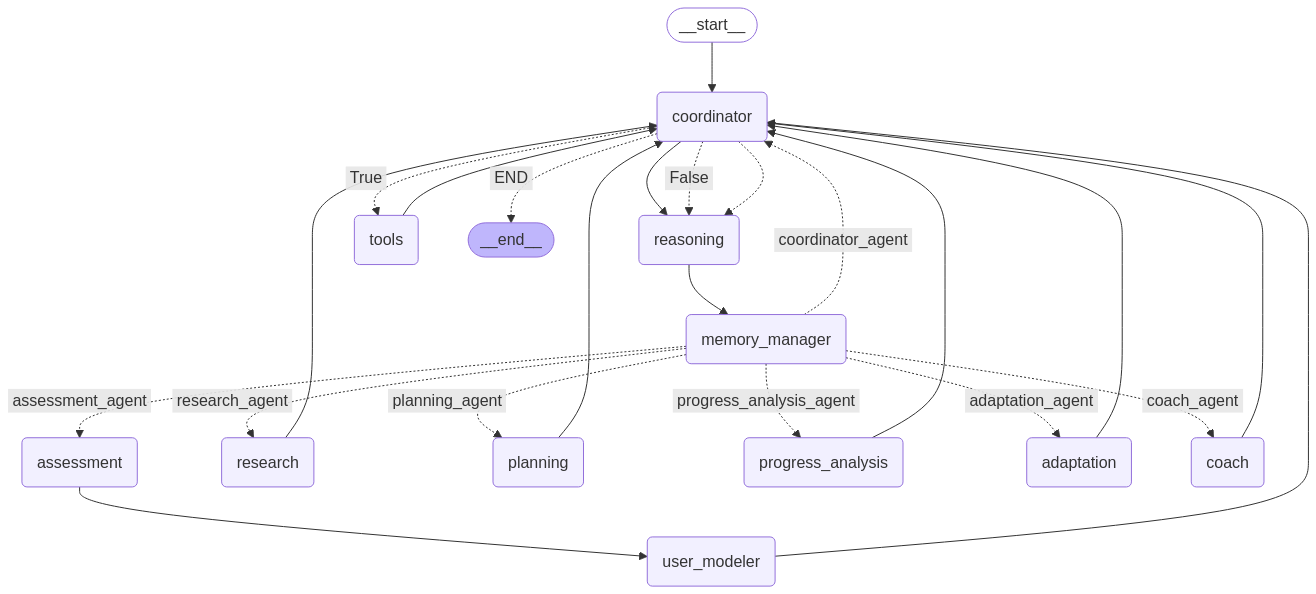

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass